# Electron / Photon Classification

In [1]:
# Importing Necessary Libraries

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.transforms import CenterCrop
from torch.utils.data import Dataset, DataLoader, random_split

import h5py

from sklearn.metrics import roc_auc_score

In [2]:
print(torch.__version__)

1.13.0


In [3]:
print(torch.version.cuda)

11.3


In [4]:
# Setting Seed
torch.manual_seed(47)
torch.cuda.manual_seed_all(47)
torch.cuda.manual_seed(47)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
# Setting device to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# Defining the Dataset class

class HDF5Dataset(Dataset):
    def __init__(self, file_e, file_p):
        self.file_e = file_e
        self.file_p = file_p
        self.data_key = 'X'
        self.file_electron = h5py.File(self.file_e, 'r')
        self.data_electron = self.file_electron[self.data_key]
        self.file_photon = h5py.File(self.file_p, 'r')
        self.data_photon = self.file_photon[self.data_key]
        self.data = np.concatenate((self.data_electron, self.data_photon), axis=0)
        self.labels = np.concatenate((np.ones(self.data_electron.shape[0]), np.zeros(self.data_photon.shape[0])), axis=0)
        #print(np.sum(self.labels))
        self.labels = np.expand_dims(self.labels, axis=1)
        #mean = np.mean(self.data)
        #print(mean)
        #std = np.std(self.data)
        #print(std)
        #self.data = (self.data - mean)/std


    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx]), torch.from_numpy(self.labels[idx])

    def close(self):
        self.file_electrons.close()
        self.file_photon.close()

In [7]:
# Making training, validation and test datasets
# train data : 80%, validation data : 10%, testing data : 10%

file_e = '/kaggle/input/electrons-and-photons/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
file_p = '/kaggle/input/electrons-and-photons/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
dataset = HDF5Dataset(file_e, file_p)

train_size = np.int32(0.8 * len(dataset))
test_size = np.int32(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size

train_data, test_data, val_data = random_split(dataset, [train_size, test_size, val_size])

train_loader = DataLoader(train_data, batch_size=200, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=200, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=200, shuffle=True, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
# Defining the model architecture

class Net (nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(2, 32, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        xmax, xmin = x.min(), x.max()
        x = (x - xmin)/(xmax - xmin)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = torch.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x

In [9]:
# model loss and optimizer
model = Net().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
# Training

epochs = 150
min_val_loss = np.inf

train_losses = []
val_losses = []
train_aucs = []
val_aucs = []
counter = 0

for e in range(epochs):
    train_loss = 0.0
    train_auc = 0.0
    i = 0
    for data in train_loader: # Training Loop
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        #print(inputs.shape)
        outputs = model(inputs)
        labels , outputs = labels.type(torch.FloatTensor),outputs.type(torch.FloatTensor)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        with torch.no_grad():
            train_auc += roc_auc_score(labels.numpy(), outputs.numpy())
        
        if i % 100 == 99:    # Print every 100 mini-batches
            print('[Epoch %d, Batch %d] Loss: %.3f Accuracy: %.3f' %
                  (e + 1, i + 1, train_loss / 100, train_auc / 100))
            train_losses.append(train_loss / 100)
            train_aucs.append(train_auc / 100)
            train_loss = 0.0
            train_auc = 0.0
        
        i += 1
    
    with torch.no_grad():
        val_loss = 0.0
        val_auc = 0.0
        model.eval()
        for data in val_loader: # Validation Loop
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels , outputs = labels.type(torch.FloatTensor),outputs.type(torch.FloatTensor)
            loss = criterion(outputs,labels)
            val_loss += loss.item()
            val_auc += roc_auc_score(labels.numpy(), outputs.numpy())
        
    print(f'Epoch {e+1} Val Loss: {val_loss / len(val_loader)} \t\t Val Accuracy: {val_auc / len(val_loader)}')
    
    val_losses.append(val_loss / len(val_loader))
    val_aucs.append(val_auc / len(val_loader))
     
    if min_val_loss > val_loss:
        print(f'Validation Loss Decreased({min_val_loss:.6f}--->{val_loss:.6f}) \t Saving The Model')
        min_val_loss = val_loss
        counter = 0 
            
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')
        
    else:
        # Early Stopping
        counter += 1
        if counter >= 15:
            print('Training Stopped : \t\t Loss did not decrease for 15 epochs.')
            break
        

[Epoch 1, Batch 100] Loss: 0.686 Accuracy: 0.572
[Epoch 1, Batch 200] Loss: 0.678 Accuracy: 0.599
[Epoch 1, Batch 300] Loss: 0.671 Accuracy: 0.619
[Epoch 1, Batch 400] Loss: 0.667 Accuracy: 0.627
[Epoch 1, Batch 500] Loss: 0.662 Accuracy: 0.636
[Epoch 1, Batch 600] Loss: 0.659 Accuracy: 0.644
[Epoch 1, Batch 700] Loss: 0.658 Accuracy: 0.648
[Epoch 1, Batch 800] Loss: 0.657 Accuracy: 0.647
[Epoch 1, Batch 900] Loss: 0.658 Accuracy: 0.644
[Epoch 1, Batch 1000] Loss: 0.653 Accuracy: 0.654
[Epoch 1, Batch 1100] Loss: 0.656 Accuracy: 0.650
[Epoch 1, Batch 1200] Loss: 0.652 Accuracy: 0.660
[Epoch 1, Batch 1300] Loss: 0.653 Accuracy: 0.654
[Epoch 1, Batch 1400] Loss: 0.655 Accuracy: 0.654
[Epoch 1, Batch 1500] Loss: 0.648 Accuracy: 0.664
[Epoch 1, Batch 1600] Loss: 0.652 Accuracy: 0.659
[Epoch 1, Batch 1700] Loss: 0.646 Accuracy: 0.670
[Epoch 1, Batch 1800] Loss: 0.649 Accuracy: 0.668
[Epoch 1, Batch 1900] Loss: 0.652 Accuracy: 0.661


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 Val Loss: 0.6793571413760204 		 Val Accuracy: 0.6458517859247699
Validation Loss Decreased(inf--->169.159928) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 2, Batch 100] Loss: 0.675 Accuracy: 0.637
[Epoch 2, Batch 200] Loss: 0.660 Accuracy: 0.653
[Epoch 2, Batch 300] Loss: 0.657 Accuracy: 0.659
[Epoch 2, Batch 400] Loss: 0.655 Accuracy: 0.657
[Epoch 2, Batch 500] Loss: 0.655 Accuracy: 0.658
[Epoch 2, Batch 600] Loss: 0.653 Accuracy: 0.665
[Epoch 2, Batch 700] Loss: 0.652 Accuracy: 0.664
[Epoch 2, Batch 800] Loss: 0.652 Accuracy: 0.662
[Epoch 2, Batch 900] Loss: 0.648 Accuracy: 0.674
[Epoch 2, Batch 1000] Loss: 0.644 Accuracy: 0.678
[Epoch 2, Batch 1100] Loss: 0.652 Accuracy: 0.664
[Epoch 2, Batch 1200] Loss: 0.647 Accuracy: 0.676
[Epoch 2, Batch 1300] Loss: 0.644 Accuracy: 0.679
[Epoch 2, Batch 1400] Loss: 0.643 Accuracy: 0.678
[Epoch 2, Batch 1500] Loss: 0.646 Accuracy: 0.673
[Epoch 2, Batch 1600] Loss: 0.648 Accuracy: 0.678
[Epoch 2, Batch 1700] Loss: 0.640 Accuracy: 0.683
[Epoch 2, Batch 1800] Loss: 0.639 Accuracy: 0.685
[Epoch 2, Batch 1900] Loss: 0.645 Accuracy: 0.679


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 Val Loss: 0.637704232370997 		 Val Accuracy: 0.6894544796507677
Validation Loss Decreased(169.159928--->158.788354) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 3, Batch 100] Loss: 0.649 Accuracy: 0.677
[Epoch 3, Batch 200] Loss: 0.641 Accuracy: 0.686
[Epoch 3, Batch 300] Loss: 0.638 Accuracy: 0.690
[Epoch 3, Batch 400] Loss: 0.639 Accuracy: 0.689
[Epoch 3, Batch 500] Loss: 0.634 Accuracy: 0.695
[Epoch 3, Batch 600] Loss: 0.641 Accuracy: 0.688
[Epoch 3, Batch 700] Loss: 0.644 Accuracy: 0.687
[Epoch 3, Batch 800] Loss: 0.639 Accuracy: 0.687
[Epoch 3, Batch 900] Loss: 0.634 Accuracy: 0.696
[Epoch 3, Batch 1000] Loss: 0.634 Accuracy: 0.697
[Epoch 3, Batch 1100] Loss: 0.636 Accuracy: 0.697
[Epoch 3, Batch 1200] Loss: 0.638 Accuracy: 0.689
[Epoch 3, Batch 1300] Loss: 0.634 Accuracy: 0.701
[Epoch 3, Batch 1400] Loss: 0.641 Accuracy: 0.688
[Epoch 3, Batch 1500] Loss: 0.635 Accuracy: 0.700
[Epoch 3, Batch 1600] Loss: 0.631 Accuracy: 0.703
[Epoch 3, Batch 1700] Loss: 0.634 Accuracy: 0.698
[Epoch 3, Batch 1800] Loss: 0.629 Accuracy: 0.706
[Epoch 3, Batch 1900] Loss: 0.637 Accuracy: 0.697


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 Val Loss: 0.6281036504779953 		 Val Accuracy: 0.7027636441896875
Validation Loss Decreased(158.788354--->156.397809) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 4, Batch 100] Loss: 0.630 Accuracy: 0.702
[Epoch 4, Batch 200] Loss: 0.627 Accuracy: 0.707
[Epoch 4, Batch 300] Loss: 0.628 Accuracy: 0.709
[Epoch 4, Batch 400] Loss: 0.634 Accuracy: 0.698
[Epoch 4, Batch 500] Loss: 0.628 Accuracy: 0.708
[Epoch 4, Batch 600] Loss: 0.628 Accuracy: 0.707
[Epoch 4, Batch 700] Loss: 0.625 Accuracy: 0.713
[Epoch 4, Batch 800] Loss: 0.636 Accuracy: 0.705
[Epoch 4, Batch 900] Loss: 0.626 Accuracy: 0.711
[Epoch 4, Batch 1000] Loss: 0.624 Accuracy: 0.716
[Epoch 4, Batch 1100] Loss: 0.630 Accuracy: 0.709
[Epoch 4, Batch 1200] Loss: 0.629 Accuracy: 0.709
[Epoch 4, Batch 1300] Loss: 0.625 Accuracy: 0.713
[Epoch 4, Batch 1400] Loss: 0.630 Accuracy: 0.706
[Epoch 4, Batch 1500] Loss: 0.624 Accuracy: 0.712
[Epoch 4, Batch 1600] Loss: 0.632 Accuracy: 0.710
[Epoch 4, Batch 1700] Loss: 0.623 Accuracy: 0.718
[Epoch 4, Batch 1800] Loss: 0.621 Accuracy: 0.719
[Epoch 4, Batch 1900] Loss: 0.630 Accuracy: 0.708


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 Val Loss: 0.61624143520991 		 Val Accuracy: 0.7203644164444882
Validation Loss Decreased(156.397809--->153.444117) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 5, Batch 100] Loss: 0.622 Accuracy: 0.716
[Epoch 5, Batch 200] Loss: 0.623 Accuracy: 0.718
[Epoch 5, Batch 300] Loss: 0.622 Accuracy: 0.714
[Epoch 5, Batch 400] Loss: 0.617 Accuracy: 0.725
[Epoch 5, Batch 500] Loss: 0.620 Accuracy: 0.717
[Epoch 5, Batch 600] Loss: 0.620 Accuracy: 0.720
[Epoch 5, Batch 700] Loss: 0.619 Accuracy: 0.723
[Epoch 5, Batch 800] Loss: 0.613 Accuracy: 0.730
[Epoch 5, Batch 900] Loss: 0.617 Accuracy: 0.724
[Epoch 5, Batch 1000] Loss: 0.615 Accuracy: 0.726
[Epoch 5, Batch 1100] Loss: 0.624 Accuracy: 0.722
[Epoch 5, Batch 1200] Loss: 0.622 Accuracy: 0.720
[Epoch 5, Batch 1300] Loss: 0.617 Accuracy: 0.724
[Epoch 5, Batch 1400] Loss: 0.622 Accuracy: 0.720
[Epoch 5, Batch 1500] Loss: 0.619 Accuracy: 0.727
[Epoch 5, Batch 1600] Loss: 0.612 Accuracy: 0.731
[Epoch 5, Batch 1700] Loss: 0.611 Accuracy: 0.733
[Epoch 5, Batch 1800] Loss: 0.616 Accuracy: 0.724
[Epoch 5, Batch 1900] Loss: 0.614 Accuracy: 0.729


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 Val Loss: 0.616707725457877 		 Val Accuracy: 0.7296456754871765


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 6, Batch 100] Loss: 0.613 Accuracy: 0.730
[Epoch 6, Batch 200] Loss: 0.611 Accuracy: 0.730
[Epoch 6, Batch 300] Loss: 0.616 Accuracy: 0.730
[Epoch 6, Batch 400] Loss: 0.611 Accuracy: 0.732
[Epoch 6, Batch 500] Loss: 0.613 Accuracy: 0.732
[Epoch 6, Batch 600] Loss: 0.611 Accuracy: 0.733
[Epoch 6, Batch 700] Loss: 0.610 Accuracy: 0.734
[Epoch 6, Batch 800] Loss: 0.614 Accuracy: 0.729
[Epoch 6, Batch 900] Loss: 0.611 Accuracy: 0.735
[Epoch 6, Batch 1000] Loss: 0.609 Accuracy: 0.739
[Epoch 6, Batch 1100] Loss: 0.609 Accuracy: 0.736
[Epoch 6, Batch 1200] Loss: 0.608 Accuracy: 0.739
[Epoch 6, Batch 1300] Loss: 0.609 Accuracy: 0.735
[Epoch 6, Batch 1400] Loss: 0.610 Accuracy: 0.731
[Epoch 6, Batch 1500] Loss: 0.605 Accuracy: 0.741
[Epoch 6, Batch 1600] Loss: 0.602 Accuracy: 0.743
[Epoch 6, Batch 1700] Loss: 0.606 Accuracy: 0.740
[Epoch 6, Batch 1800] Loss: 0.607 Accuracy: 0.738
[Epoch 6, Batch 1900] Loss: 0.614 Accuracy: 0.732


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 Val Loss: 0.6034929900763025 		 Val Accuracy: 0.7399124903341802
Validation Loss Decreased(153.444117--->150.269755) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 7, Batch 100] Loss: 0.605 Accuracy: 0.741
[Epoch 7, Batch 200] Loss: 0.601 Accuracy: 0.744
[Epoch 7, Batch 300] Loss: 0.612 Accuracy: 0.733
[Epoch 7, Batch 400] Loss: 0.600 Accuracy: 0.744
[Epoch 7, Batch 500] Loss: 0.599 Accuracy: 0.745
[Epoch 7, Batch 600] Loss: 0.610 Accuracy: 0.737
[Epoch 7, Batch 700] Loss: 0.606 Accuracy: 0.740
[Epoch 7, Batch 800] Loss: 0.608 Accuracy: 0.738
[Epoch 7, Batch 900] Loss: 0.608 Accuracy: 0.741
[Epoch 7, Batch 1000] Loss: 0.598 Accuracy: 0.746
[Epoch 7, Batch 1100] Loss: 0.596 Accuracy: 0.750
[Epoch 7, Batch 1200] Loss: 0.604 Accuracy: 0.741
[Epoch 7, Batch 1300] Loss: 0.604 Accuracy: 0.742
[Epoch 7, Batch 1400] Loss: 0.602 Accuracy: 0.743
[Epoch 7, Batch 1500] Loss: 0.598 Accuracy: 0.747
[Epoch 7, Batch 1600] Loss: 0.603 Accuracy: 0.742
[Epoch 7, Batch 1700] Loss: 0.607 Accuracy: 0.739
[Epoch 7, Batch 1800] Loss: 0.605 Accuracy: 0.740
[Epoch 7, Batch 1900] Loss: 0.606 Accuracy: 0.740


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 Val Loss: 0.5926724595717158 		 Val Accuracy: 0.7526630270320291
Validation Loss Decreased(150.269755--->147.575442) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 8, Batch 100] Loss: 0.603 Accuracy: 0.744
[Epoch 8, Batch 200] Loss: 0.600 Accuracy: 0.748
[Epoch 8, Batch 300] Loss: 0.599 Accuracy: 0.746
[Epoch 8, Batch 400] Loss: 0.597 Accuracy: 0.748
[Epoch 8, Batch 500] Loss: 0.594 Accuracy: 0.750
[Epoch 8, Batch 600] Loss: 0.600 Accuracy: 0.747
[Epoch 8, Batch 700] Loss: 0.604 Accuracy: 0.745
[Epoch 8, Batch 800] Loss: 0.597 Accuracy: 0.751
[Epoch 8, Batch 900] Loss: 0.593 Accuracy: 0.754
[Epoch 8, Batch 1000] Loss: 0.602 Accuracy: 0.745
[Epoch 8, Batch 1100] Loss: 0.595 Accuracy: 0.752
[Epoch 8, Batch 1200] Loss: 0.605 Accuracy: 0.745
[Epoch 8, Batch 1300] Loss: 0.599 Accuracy: 0.747
[Epoch 8, Batch 1400] Loss: 0.592 Accuracy: 0.754
[Epoch 8, Batch 1500] Loss: 0.606 Accuracy: 0.740
[Epoch 8, Batch 1600] Loss: 0.592 Accuracy: 0.755
[Epoch 8, Batch 1700] Loss: 0.597 Accuracy: 0.748
[Epoch 8, Batch 1800] Loss: 0.596 Accuracy: 0.754
[Epoch 8, Batch 1900] Loss: 0.601 Accuracy: 0.745


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 Val Loss: 0.5927570914647665 		 Val Accuracy: 0.7517371758459507


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 9, Batch 100] Loss: 0.599 Accuracy: 0.748
[Epoch 9, Batch 200] Loss: 0.592 Accuracy: 0.754
[Epoch 9, Batch 300] Loss: 0.597 Accuracy: 0.748
[Epoch 9, Batch 400] Loss: 0.590 Accuracy: 0.755
[Epoch 9, Batch 500] Loss: 0.597 Accuracy: 0.751
[Epoch 9, Batch 600] Loss: 0.594 Accuracy: 0.752
[Epoch 9, Batch 700] Loss: 0.589 Accuracy: 0.756
[Epoch 9, Batch 800] Loss: 0.593 Accuracy: 0.754
[Epoch 9, Batch 900] Loss: 0.593 Accuracy: 0.757
[Epoch 9, Batch 1000] Loss: 0.590 Accuracy: 0.758
[Epoch 9, Batch 1100] Loss: 0.598 Accuracy: 0.749
[Epoch 9, Batch 1200] Loss: 0.601 Accuracy: 0.745
[Epoch 9, Batch 1300] Loss: 0.592 Accuracy: 0.757
[Epoch 9, Batch 1400] Loss: 0.593 Accuracy: 0.752
[Epoch 9, Batch 1500] Loss: 0.594 Accuracy: 0.753
[Epoch 9, Batch 1600] Loss: 0.593 Accuracy: 0.757
[Epoch 9, Batch 1700] Loss: 0.595 Accuracy: 0.754
[Epoch 9, Batch 1800] Loss: 0.590 Accuracy: 0.754
[Epoch 9, Batch 1900] Loss: 0.596 Accuracy: 0.753


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 Val Loss: 0.5829954532734362 		 Val Accuracy: 0.7609213959415597
Validation Loss Decreased(147.575442--->145.165868) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 10, Batch 100] Loss: 0.590 Accuracy: 0.758
[Epoch 10, Batch 200] Loss: 0.595 Accuracy: 0.751
[Epoch 10, Batch 300] Loss: 0.588 Accuracy: 0.760
[Epoch 10, Batch 400] Loss: 0.591 Accuracy: 0.755
[Epoch 10, Batch 500] Loss: 0.597 Accuracy: 0.749
[Epoch 10, Batch 600] Loss: 0.600 Accuracy: 0.749
[Epoch 10, Batch 700] Loss: 0.585 Accuracy: 0.761
[Epoch 10, Batch 800] Loss: 0.597 Accuracy: 0.753
[Epoch 10, Batch 900] Loss: 0.593 Accuracy: 0.754
[Epoch 10, Batch 1000] Loss: 0.590 Accuracy: 0.758
[Epoch 10, Batch 1100] Loss: 0.585 Accuracy: 0.762
[Epoch 10, Batch 1200] Loss: 0.582 Accuracy: 0.767
[Epoch 10, Batch 1300] Loss: 0.590 Accuracy: 0.757
[Epoch 10, Batch 1400] Loss: 0.587 Accuracy: 0.761
[Epoch 10, Batch 1500] Loss: 0.587 Accuracy: 0.759
[Epoch 10, Batch 1600] Loss: 0.580 Accuracy: 0.766
[Epoch 10, Batch 1700] Loss: 0.591 Accuracy: 0.758
[Epoch 10, Batch 1800] Loss: 0.594 Accuracy: 0.758
[Epoch 10, Batch 1900] Loss: 0.585 Accuracy: 0.764


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 Val Loss: 0.5929344739301138 		 Val Accuracy: 0.7552329771627339


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 11, Batch 100] Loss: 0.588 Accuracy: 0.762
[Epoch 11, Batch 200] Loss: 0.584 Accuracy: 0.764
[Epoch 11, Batch 300] Loss: 0.584 Accuracy: 0.762
[Epoch 11, Batch 400] Loss: 0.587 Accuracy: 0.762
[Epoch 11, Batch 500] Loss: 0.580 Accuracy: 0.767
[Epoch 11, Batch 600] Loss: 0.591 Accuracy: 0.757
[Epoch 11, Batch 700] Loss: 0.591 Accuracy: 0.756
[Epoch 11, Batch 800] Loss: 0.592 Accuracy: 0.758
[Epoch 11, Batch 900] Loss: 0.581 Accuracy: 0.765
[Epoch 11, Batch 1000] Loss: 0.584 Accuracy: 0.764
[Epoch 11, Batch 1100] Loss: 0.588 Accuracy: 0.762
[Epoch 11, Batch 1200] Loss: 0.592 Accuracy: 0.756
[Epoch 11, Batch 1300] Loss: 0.585 Accuracy: 0.761
[Epoch 11, Batch 1400] Loss: 0.588 Accuracy: 0.760
[Epoch 11, Batch 1500] Loss: 0.585 Accuracy: 0.764
[Epoch 11, Batch 1600] Loss: 0.581 Accuracy: 0.765
[Epoch 11, Batch 1700] Loss: 0.592 Accuracy: 0.755
[Epoch 11, Batch 1800] Loss: 0.585 Accuracy: 0.764
[Epoch 11, Batch 1900] Loss: 0.588 Accuracy: 0.757


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 Val Loss: 0.5791939334218282 		 Val Accuracy: 0.768256396196726
Validation Loss Decreased(145.165868--->144.219289) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 12, Batch 100] Loss: 0.585 Accuracy: 0.764
[Epoch 12, Batch 200] Loss: 0.586 Accuracy: 0.762
[Epoch 12, Batch 300] Loss: 0.591 Accuracy: 0.756
[Epoch 12, Batch 400] Loss: 0.589 Accuracy: 0.761
[Epoch 12, Batch 500] Loss: 0.586 Accuracy: 0.764
[Epoch 12, Batch 600] Loss: 0.582 Accuracy: 0.768
[Epoch 12, Batch 700] Loss: 0.584 Accuracy: 0.764
[Epoch 12, Batch 800] Loss: 0.582 Accuracy: 0.766
[Epoch 12, Batch 900] Loss: 0.582 Accuracy: 0.765
[Epoch 12, Batch 1000] Loss: 0.584 Accuracy: 0.764
[Epoch 12, Batch 1100] Loss: 0.580 Accuracy: 0.771
[Epoch 12, Batch 1200] Loss: 0.581 Accuracy: 0.766
[Epoch 12, Batch 1300] Loss: 0.583 Accuracy: 0.762
[Epoch 12, Batch 1400] Loss: 0.574 Accuracy: 0.775
[Epoch 12, Batch 1500] Loss: 0.577 Accuracy: 0.770
[Epoch 12, Batch 1600] Loss: 0.587 Accuracy: 0.761
[Epoch 12, Batch 1700] Loss: 0.578 Accuracy: 0.769
[Epoch 12, Batch 1800] Loss: 0.582 Accuracy: 0.767
[Epoch 12, Batch 1900] Loss: 0.623 Accuracy: 0.720


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 Val Loss: 0.6249266716849852 		 Val Accuracy: 0.7315272955458756


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 13, Batch 100] Loss: 0.607 Accuracy: 0.736
[Epoch 13, Batch 200] Loss: 0.606 Accuracy: 0.738
[Epoch 13, Batch 300] Loss: 0.600 Accuracy: 0.745
[Epoch 13, Batch 400] Loss: 0.595 Accuracy: 0.752
[Epoch 13, Batch 500] Loss: 0.604 Accuracy: 0.740
[Epoch 13, Batch 600] Loss: 0.596 Accuracy: 0.752
[Epoch 13, Batch 700] Loss: 0.603 Accuracy: 0.741
[Epoch 13, Batch 800] Loss: 0.600 Accuracy: 0.745
[Epoch 13, Batch 900] Loss: 0.596 Accuracy: 0.752
[Epoch 13, Batch 1000] Loss: 0.600 Accuracy: 0.745
[Epoch 13, Batch 1100] Loss: 0.596 Accuracy: 0.750
[Epoch 13, Batch 1200] Loss: 0.592 Accuracy: 0.753
[Epoch 13, Batch 1300] Loss: 0.598 Accuracy: 0.746
[Epoch 13, Batch 1400] Loss: 0.601 Accuracy: 0.745
[Epoch 13, Batch 1500] Loss: 0.589 Accuracy: 0.757
[Epoch 13, Batch 1600] Loss: 0.595 Accuracy: 0.753
[Epoch 13, Batch 1700] Loss: 0.595 Accuracy: 0.751
[Epoch 13, Batch 1800] Loss: 0.596 Accuracy: 0.751
[Epoch 13, Batch 1900] Loss: 0.591 Accuracy: 0.758


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 Val Loss: 0.5858440054468361 		 Val Accuracy: 0.7595840305698676


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 14, Batch 100] Loss: 0.594 Accuracy: 0.752
[Epoch 14, Batch 200] Loss: 0.584 Accuracy: 0.762
[Epoch 14, Batch 300] Loss: 0.586 Accuracy: 0.762
[Epoch 14, Batch 400] Loss: 0.588 Accuracy: 0.757
[Epoch 14, Batch 500] Loss: 0.590 Accuracy: 0.756
[Epoch 14, Batch 600] Loss: 0.584 Accuracy: 0.764
[Epoch 14, Batch 700] Loss: 0.582 Accuracy: 0.766
[Epoch 14, Batch 800] Loss: 0.588 Accuracy: 0.759
[Epoch 14, Batch 900] Loss: 0.589 Accuracy: 0.757
[Epoch 14, Batch 1000] Loss: 0.588 Accuracy: 0.761
[Epoch 14, Batch 1100] Loss: 0.590 Accuracy: 0.757
[Epoch 14, Batch 1200] Loss: 0.593 Accuracy: 0.754
[Epoch 14, Batch 1300] Loss: 0.591 Accuracy: 0.756
[Epoch 14, Batch 1400] Loss: 0.586 Accuracy: 0.763
[Epoch 14, Batch 1500] Loss: 0.588 Accuracy: 0.759
[Epoch 14, Batch 1600] Loss: 0.583 Accuracy: 0.763
[Epoch 14, Batch 1700] Loss: 0.581 Accuracy: 0.766
[Epoch 14, Batch 1800] Loss: 0.594 Accuracy: 0.755
[Epoch 14, Batch 1900] Loss: 0.593 Accuracy: 0.756


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 Val Loss: 0.5792722072467268 		 Val Accuracy: 0.7662773169716499


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 15, Batch 100] Loss: 0.582 Accuracy: 0.766
[Epoch 15, Batch 200] Loss: 0.579 Accuracy: 0.767
[Epoch 15, Batch 300] Loss: 0.587 Accuracy: 0.762
[Epoch 15, Batch 400] Loss: 0.585 Accuracy: 0.764
[Epoch 15, Batch 500] Loss: 0.578 Accuracy: 0.769
[Epoch 15, Batch 600] Loss: 0.576 Accuracy: 0.771
[Epoch 15, Batch 700] Loss: 0.581 Accuracy: 0.768
[Epoch 15, Batch 800] Loss: 0.580 Accuracy: 0.770
[Epoch 15, Batch 900] Loss: 0.582 Accuracy: 0.766
[Epoch 15, Batch 1000] Loss: 0.616 Accuracy: 0.724
[Epoch 15, Batch 1100] Loss: 0.610 Accuracy: 0.733
[Epoch 15, Batch 1200] Loss: 0.598 Accuracy: 0.746
[Epoch 15, Batch 1300] Loss: 0.601 Accuracy: 0.748
[Epoch 15, Batch 1400] Loss: 0.592 Accuracy: 0.754
[Epoch 15, Batch 1500] Loss: 0.595 Accuracy: 0.750
[Epoch 15, Batch 1600] Loss: 0.595 Accuracy: 0.752
[Epoch 15, Batch 1700] Loss: 0.596 Accuracy: 0.750
[Epoch 15, Batch 1800] Loss: 0.588 Accuracy: 0.758
[Epoch 15, Batch 1900] Loss: 0.598 Accuracy: 0.750


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 Val Loss: 0.5973152338740337 		 Val Accuracy: 0.7485888089430074


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 16, Batch 100] Loss: 0.590 Accuracy: 0.757
[Epoch 16, Batch 200] Loss: 0.592 Accuracy: 0.753
[Epoch 16, Batch 300] Loss: 0.596 Accuracy: 0.752
[Epoch 16, Batch 400] Loss: 0.585 Accuracy: 0.762
[Epoch 16, Batch 500] Loss: 0.589 Accuracy: 0.759
[Epoch 16, Batch 600] Loss: 0.592 Accuracy: 0.755
[Epoch 16, Batch 700] Loss: 0.584 Accuracy: 0.762
[Epoch 16, Batch 800] Loss: 0.581 Accuracy: 0.766
[Epoch 16, Batch 900] Loss: 0.582 Accuracy: 0.764
[Epoch 16, Batch 1000] Loss: 0.584 Accuracy: 0.764
[Epoch 16, Batch 1100] Loss: 0.586 Accuracy: 0.761
[Epoch 16, Batch 1200] Loss: 0.588 Accuracy: 0.762
[Epoch 16, Batch 1300] Loss: 0.585 Accuracy: 0.765
[Epoch 16, Batch 1400] Loss: 0.584 Accuracy: 0.765
[Epoch 16, Batch 1500] Loss: 0.581 Accuracy: 0.766
[Epoch 16, Batch 1600] Loss: 0.582 Accuracy: 0.764
[Epoch 16, Batch 1700] Loss: 0.589 Accuracy: 0.759
[Epoch 16, Batch 1800] Loss: 0.584 Accuracy: 0.764
[Epoch 16, Batch 1900] Loss: 0.585 Accuracy: 0.762


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 Val Loss: 0.5717785172912491 		 Val Accuracy: 0.7737416391873597
Validation Loss Decreased(144.219289--->142.372851) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 17, Batch 100] Loss: 0.579 Accuracy: 0.770
[Epoch 17, Batch 200] Loss: 0.588 Accuracy: 0.762
[Epoch 17, Batch 300] Loss: 0.581 Accuracy: 0.766
[Epoch 17, Batch 400] Loss: 0.577 Accuracy: 0.769
[Epoch 17, Batch 500] Loss: 0.576 Accuracy: 0.770
[Epoch 17, Batch 600] Loss: 0.585 Accuracy: 0.761
[Epoch 17, Batch 700] Loss: 0.572 Accuracy: 0.775
[Epoch 17, Batch 800] Loss: 0.579 Accuracy: 0.768
[Epoch 17, Batch 900] Loss: 0.573 Accuracy: 0.773
[Epoch 17, Batch 1000] Loss: 0.581 Accuracy: 0.768
[Epoch 17, Batch 1100] Loss: 0.574 Accuracy: 0.773
[Epoch 17, Batch 1200] Loss: 0.580 Accuracy: 0.766
[Epoch 17, Batch 1300] Loss: 0.582 Accuracy: 0.765
[Epoch 17, Batch 1400] Loss: 0.575 Accuracy: 0.771
[Epoch 17, Batch 1500] Loss: 0.586 Accuracy: 0.763
[Epoch 17, Batch 1600] Loss: 0.574 Accuracy: 0.772
[Epoch 17, Batch 1700] Loss: 0.576 Accuracy: 0.774
[Epoch 17, Batch 1800] Loss: 0.576 Accuracy: 0.771
[Epoch 17, Batch 1900] Loss: 0.575 Accuracy: 0.774


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 Val Loss: 0.5709648956974827 		 Val Accuracy: 0.7754482954539902
Validation Loss Decreased(142.372851--->142.170259) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 18, Batch 100] Loss: 0.576 Accuracy: 0.770
[Epoch 18, Batch 200] Loss: 0.573 Accuracy: 0.775
[Epoch 18, Batch 300] Loss: 0.578 Accuracy: 0.770
[Epoch 18, Batch 400] Loss: 0.581 Accuracy: 0.769
[Epoch 18, Batch 500] Loss: 0.578 Accuracy: 0.770
[Epoch 18, Batch 600] Loss: 0.575 Accuracy: 0.772
[Epoch 18, Batch 700] Loss: 0.573 Accuracy: 0.777
[Epoch 18, Batch 800] Loss: 0.582 Accuracy: 0.768
[Epoch 18, Batch 900] Loss: 0.576 Accuracy: 0.772
[Epoch 18, Batch 1000] Loss: 0.571 Accuracy: 0.778
[Epoch 18, Batch 1100] Loss: 0.575 Accuracy: 0.772
[Epoch 18, Batch 1200] Loss: 0.575 Accuracy: 0.774
[Epoch 18, Batch 1300] Loss: 0.580 Accuracy: 0.769
[Epoch 18, Batch 1400] Loss: 0.571 Accuracy: 0.775
[Epoch 18, Batch 1500] Loss: 0.566 Accuracy: 0.782
[Epoch 18, Batch 1600] Loss: 0.572 Accuracy: 0.776
[Epoch 18, Batch 1700] Loss: 0.571 Accuracy: 0.776
[Epoch 18, Batch 1800] Loss: 0.581 Accuracy: 0.768
[Epoch 18, Batch 1900] Loss: 0.585 Accuracy: 0.764


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 Val Loss: 0.5734918206092344 		 Val Accuracy: 0.7760236703933984


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 19, Batch 100] Loss: 0.572 Accuracy: 0.777
[Epoch 19, Batch 200] Loss: 0.576 Accuracy: 0.773
[Epoch 19, Batch 300] Loss: 0.567 Accuracy: 0.779
[Epoch 19, Batch 400] Loss: 0.572 Accuracy: 0.775
[Epoch 19, Batch 500] Loss: 0.570 Accuracy: 0.777
[Epoch 19, Batch 600] Loss: 0.573 Accuracy: 0.775
[Epoch 19, Batch 700] Loss: 0.584 Accuracy: 0.766
[Epoch 19, Batch 800] Loss: 0.573 Accuracy: 0.773
[Epoch 19, Batch 900] Loss: 0.570 Accuracy: 0.778
[Epoch 19, Batch 1000] Loss: 0.572 Accuracy: 0.776
[Epoch 19, Batch 1100] Loss: 0.570 Accuracy: 0.780
[Epoch 19, Batch 1200] Loss: 0.576 Accuracy: 0.773
[Epoch 19, Batch 1300] Loss: 0.568 Accuracy: 0.781
[Epoch 19, Batch 1400] Loss: 0.576 Accuracy: 0.772
[Epoch 19, Batch 1500] Loss: 0.576 Accuracy: 0.774
[Epoch 19, Batch 1600] Loss: 0.572 Accuracy: 0.775
[Epoch 19, Batch 1700] Loss: 0.569 Accuracy: 0.779
[Epoch 19, Batch 1800] Loss: 0.571 Accuracy: 0.780
[Epoch 19, Batch 1900] Loss: 0.575 Accuracy: 0.774


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 Val Loss: 0.5643131835872389 		 Val Accuracy: 0.7823378547152293
Validation Loss Decreased(142.170259--->140.513983) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 20, Batch 100] Loss: 0.576 Accuracy: 0.774
[Epoch 20, Batch 200] Loss: 0.574 Accuracy: 0.775
[Epoch 20, Batch 300] Loss: 0.573 Accuracy: 0.773
[Epoch 20, Batch 400] Loss: 0.572 Accuracy: 0.775
[Epoch 20, Batch 500] Loss: 0.572 Accuracy: 0.776
[Epoch 20, Batch 600] Loss: 0.570 Accuracy: 0.778
[Epoch 20, Batch 700] Loss: 0.568 Accuracy: 0.781
[Epoch 20, Batch 800] Loss: 0.571 Accuracy: 0.776
[Epoch 20, Batch 900] Loss: 0.571 Accuracy: 0.775
[Epoch 20, Batch 1000] Loss: 0.561 Accuracy: 0.785
[Epoch 20, Batch 1100] Loss: 0.565 Accuracy: 0.783
[Epoch 20, Batch 1200] Loss: 0.568 Accuracy: 0.780
[Epoch 20, Batch 1300] Loss: 0.571 Accuracy: 0.778
[Epoch 20, Batch 1400] Loss: 0.569 Accuracy: 0.778
[Epoch 20, Batch 1500] Loss: 0.564 Accuracy: 0.785
[Epoch 20, Batch 1600] Loss: 0.568 Accuracy: 0.780
[Epoch 20, Batch 1700] Loss: 0.568 Accuracy: 0.779
[Epoch 20, Batch 1800] Loss: 0.562 Accuracy: 0.785
[Epoch 20, Batch 1900] Loss: 0.561 Accuracy: 0.785


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 20 Val Loss: 0.5643079271278229 		 Val Accuracy: 0.7841305671195591
Validation Loss Decreased(140.513983--->140.512674) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 21, Batch 100] Loss: 0.569 Accuracy: 0.780
[Epoch 21, Batch 200] Loss: 0.567 Accuracy: 0.781
[Epoch 21, Batch 300] Loss: 0.566 Accuracy: 0.781
[Epoch 21, Batch 400] Loss: 0.566 Accuracy: 0.780
[Epoch 21, Batch 500] Loss: 0.561 Accuracy: 0.786
[Epoch 21, Batch 600] Loss: 0.564 Accuracy: 0.784
[Epoch 21, Batch 700] Loss: 0.574 Accuracy: 0.775
[Epoch 21, Batch 800] Loss: 0.564 Accuracy: 0.785
[Epoch 21, Batch 900] Loss: 0.567 Accuracy: 0.781
[Epoch 21, Batch 1000] Loss: 0.564 Accuracy: 0.782
[Epoch 21, Batch 1100] Loss: 0.563 Accuracy: 0.784
[Epoch 21, Batch 1200] Loss: 0.567 Accuracy: 0.783
[Epoch 21, Batch 1300] Loss: 0.561 Accuracy: 0.785
[Epoch 21, Batch 1400] Loss: 0.561 Accuracy: 0.788
[Epoch 21, Batch 1500] Loss: 0.569 Accuracy: 0.780
[Epoch 21, Batch 1600] Loss: 0.564 Accuracy: 0.785
[Epoch 21, Batch 1700] Loss: 0.568 Accuracy: 0.780
[Epoch 21, Batch 1800] Loss: 0.569 Accuracy: 0.779
[Epoch 21, Batch 1900] Loss: 0.564 Accuracy: 0.784


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 21 Val Loss: 0.5805021569910778 		 Val Accuracy: 0.7780286115912111


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 22, Batch 100] Loss: 0.567 Accuracy: 0.780
[Epoch 22, Batch 200] Loss: 0.572 Accuracy: 0.777
[Epoch 22, Batch 300] Loss: 0.573 Accuracy: 0.778
[Epoch 22, Batch 400] Loss: 0.585 Accuracy: 0.766
[Epoch 22, Batch 500] Loss: 0.568 Accuracy: 0.780
[Epoch 22, Batch 600] Loss: 0.573 Accuracy: 0.776
[Epoch 22, Batch 700] Loss: 0.561 Accuracy: 0.788
[Epoch 22, Batch 800] Loss: 0.565 Accuracy: 0.782
[Epoch 22, Batch 900] Loss: 0.564 Accuracy: 0.784
[Epoch 22, Batch 1000] Loss: 0.570 Accuracy: 0.779
[Epoch 22, Batch 1100] Loss: 0.569 Accuracy: 0.779
[Epoch 22, Batch 1200] Loss: 0.568 Accuracy: 0.782
[Epoch 22, Batch 1300] Loss: 0.568 Accuracy: 0.780
[Epoch 22, Batch 1400] Loss: 0.573 Accuracy: 0.775
[Epoch 22, Batch 1500] Loss: 0.562 Accuracy: 0.787
[Epoch 22, Batch 1600] Loss: 0.572 Accuracy: 0.776
[Epoch 22, Batch 1700] Loss: 0.563 Accuracy: 0.784
[Epoch 22, Batch 1800] Loss: 0.562 Accuracy: 0.787
[Epoch 22, Batch 1900] Loss: 0.568 Accuracy: 0.780


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 22 Val Loss: 0.5591820003277805 		 Val Accuracy: 0.7865641225477563
Validation Loss Decreased(140.512674--->139.236318) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 23, Batch 100] Loss: 0.564 Accuracy: 0.785
[Epoch 23, Batch 200] Loss: 0.569 Accuracy: 0.779
[Epoch 23, Batch 300] Loss: 0.570 Accuracy: 0.781
[Epoch 23, Batch 400] Loss: 0.571 Accuracy: 0.779
[Epoch 23, Batch 500] Loss: 0.563 Accuracy: 0.785
[Epoch 23, Batch 600] Loss: 0.568 Accuracy: 0.779
[Epoch 23, Batch 700] Loss: 0.569 Accuracy: 0.778
[Epoch 23, Batch 800] Loss: 0.557 Accuracy: 0.790
[Epoch 23, Batch 900] Loss: 0.559 Accuracy: 0.789
[Epoch 23, Batch 1000] Loss: 0.557 Accuracy: 0.791
[Epoch 23, Batch 1100] Loss: 0.559 Accuracy: 0.789
[Epoch 23, Batch 1200] Loss: 0.563 Accuracy: 0.786
[Epoch 23, Batch 1300] Loss: 0.567 Accuracy: 0.781
[Epoch 23, Batch 1400] Loss: 0.564 Accuracy: 0.783
[Epoch 23, Batch 1500] Loss: 0.559 Accuracy: 0.787
[Epoch 23, Batch 1600] Loss: 0.563 Accuracy: 0.784
[Epoch 23, Batch 1700] Loss: 0.570 Accuracy: 0.779
[Epoch 23, Batch 1800] Loss: 0.565 Accuracy: 0.782
[Epoch 23, Batch 1900] Loss: 0.561 Accuracy: 0.787


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 23 Val Loss: 0.5571315910921518 		 Val Accuracy: 0.788932591562385
Validation Loss Decreased(139.236318--->138.725766) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 24, Batch 100] Loss: 0.562 Accuracy: 0.787
[Epoch 24, Batch 200] Loss: 0.559 Accuracy: 0.790
[Epoch 24, Batch 300] Loss: 0.571 Accuracy: 0.778
[Epoch 24, Batch 400] Loss: 0.560 Accuracy: 0.788
[Epoch 24, Batch 500] Loss: 0.556 Accuracy: 0.791
[Epoch 24, Batch 600] Loss: 0.557 Accuracy: 0.790
[Epoch 24, Batch 700] Loss: 0.556 Accuracy: 0.792
[Epoch 24, Batch 800] Loss: 0.561 Accuracy: 0.786
[Epoch 24, Batch 900] Loss: 0.565 Accuracy: 0.783
[Epoch 24, Batch 1000] Loss: 0.564 Accuracy: 0.783
[Epoch 24, Batch 1100] Loss: 0.562 Accuracy: 0.785
[Epoch 24, Batch 1200] Loss: 0.564 Accuracy: 0.786
[Epoch 24, Batch 1300] Loss: 0.562 Accuracy: 0.786
[Epoch 24, Batch 1400] Loss: 0.575 Accuracy: 0.773
[Epoch 24, Batch 1500] Loss: 0.566 Accuracy: 0.782
[Epoch 24, Batch 1600] Loss: 0.563 Accuracy: 0.786
[Epoch 24, Batch 1700] Loss: 0.557 Accuracy: 0.789
[Epoch 24, Batch 1800] Loss: 0.562 Accuracy: 0.785
[Epoch 24, Batch 1900] Loss: 0.568 Accuracy: 0.781


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 24 Val Loss: 0.5584713653867025 		 Val Accuracy: 0.7871211821892178


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 25, Batch 100] Loss: 0.562 Accuracy: 0.786
[Epoch 25, Batch 200] Loss: 0.564 Accuracy: 0.785
[Epoch 25, Batch 300] Loss: 0.563 Accuracy: 0.786
[Epoch 25, Batch 400] Loss: 0.564 Accuracy: 0.783
[Epoch 25, Batch 500] Loss: 0.562 Accuracy: 0.785
[Epoch 25, Batch 600] Loss: 0.577 Accuracy: 0.772
[Epoch 25, Batch 700] Loss: 0.564 Accuracy: 0.784
[Epoch 25, Batch 800] Loss: 0.563 Accuracy: 0.784
[Epoch 25, Batch 900] Loss: 0.566 Accuracy: 0.783
[Epoch 25, Batch 1000] Loss: 0.568 Accuracy: 0.781
[Epoch 25, Batch 1100] Loss: 0.563 Accuracy: 0.782
[Epoch 25, Batch 1200] Loss: 0.560 Accuracy: 0.789
[Epoch 25, Batch 1300] Loss: 0.565 Accuracy: 0.781
[Epoch 25, Batch 1400] Loss: 0.566 Accuracy: 0.783
[Epoch 25, Batch 1500] Loss: 0.572 Accuracy: 0.778
[Epoch 25, Batch 1600] Loss: 0.572 Accuracy: 0.774
[Epoch 25, Batch 1700] Loss: 0.571 Accuracy: 0.779
[Epoch 25, Batch 1800] Loss: 0.569 Accuracy: 0.780
[Epoch 25, Batch 1900] Loss: 0.573 Accuracy: 0.778


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 25 Val Loss: 0.5578533383497751 		 Val Accuracy: 0.7874872108916352


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 26, Batch 100] Loss: 0.558 Accuracy: 0.789
[Epoch 26, Batch 200] Loss: 0.564 Accuracy: 0.782
[Epoch 26, Batch 300] Loss: 0.587 Accuracy: 0.763
[Epoch 26, Batch 400] Loss: 0.579 Accuracy: 0.770
[Epoch 26, Batch 500] Loss: 0.566 Accuracy: 0.783
[Epoch 26, Batch 600] Loss: 0.571 Accuracy: 0.779
[Epoch 26, Batch 700] Loss: 0.564 Accuracy: 0.784
[Epoch 26, Batch 800] Loss: 0.565 Accuracy: 0.783
[Epoch 26, Batch 900] Loss: 0.566 Accuracy: 0.781
[Epoch 26, Batch 1000] Loss: 0.563 Accuracy: 0.785
[Epoch 26, Batch 1100] Loss: 0.562 Accuracy: 0.786
[Epoch 26, Batch 1200] Loss: 0.561 Accuracy: 0.786
[Epoch 26, Batch 1300] Loss: 0.567 Accuracy: 0.781
[Epoch 26, Batch 1400] Loss: 0.574 Accuracy: 0.774
[Epoch 26, Batch 1500] Loss: 0.571 Accuracy: 0.778
[Epoch 26, Batch 1600] Loss: 0.565 Accuracy: 0.783
[Epoch 26, Batch 1700] Loss: 0.568 Accuracy: 0.781
[Epoch 26, Batch 1800] Loss: 0.567 Accuracy: 0.782
[Epoch 26, Batch 1900] Loss: 0.560 Accuracy: 0.788


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 26 Val Loss: 0.564164073232666 		 Val Accuracy: 0.7865919593469444


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 27, Batch 100] Loss: 0.565 Accuracy: 0.782
[Epoch 27, Batch 200] Loss: 0.568 Accuracy: 0.781
[Epoch 27, Batch 300] Loss: 0.568 Accuracy: 0.781
[Epoch 27, Batch 400] Loss: 0.571 Accuracy: 0.779
[Epoch 27, Batch 500] Loss: 0.570 Accuracy: 0.781
[Epoch 27, Batch 600] Loss: 0.559 Accuracy: 0.788
[Epoch 27, Batch 700] Loss: 0.558 Accuracy: 0.789
[Epoch 27, Batch 800] Loss: 0.561 Accuracy: 0.785
[Epoch 27, Batch 900] Loss: 0.562 Accuracy: 0.786
[Epoch 27, Batch 1000] Loss: 0.580 Accuracy: 0.769
[Epoch 27, Batch 1100] Loss: 0.577 Accuracy: 0.771
[Epoch 27, Batch 1200] Loss: 0.569 Accuracy: 0.778
[Epoch 27, Batch 1300] Loss: 0.566 Accuracy: 0.781
[Epoch 27, Batch 1400] Loss: 0.562 Accuracy: 0.784
[Epoch 27, Batch 1500] Loss: 0.580 Accuracy: 0.771
[Epoch 27, Batch 1600] Loss: 0.577 Accuracy: 0.776
[Epoch 27, Batch 1700] Loss: 0.564 Accuracy: 0.785
[Epoch 27, Batch 1800] Loss: 0.562 Accuracy: 0.785
[Epoch 27, Batch 1900] Loss: 0.560 Accuracy: 0.788


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 27 Val Loss: 0.5599344695907041 		 Val Accuracy: 0.7870499406220107


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 28, Batch 100] Loss: 0.559 Accuracy: 0.788
[Epoch 28, Batch 200] Loss: 0.566 Accuracy: 0.782
[Epoch 28, Batch 300] Loss: 0.574 Accuracy: 0.774
[Epoch 28, Batch 400] Loss: 0.555 Accuracy: 0.789
[Epoch 28, Batch 500] Loss: 0.562 Accuracy: 0.788
[Epoch 28, Batch 600] Loss: 0.562 Accuracy: 0.784
[Epoch 28, Batch 700] Loss: 0.564 Accuracy: 0.785
[Epoch 28, Batch 800] Loss: 0.564 Accuracy: 0.782
[Epoch 28, Batch 900] Loss: 0.567 Accuracy: 0.782
[Epoch 28, Batch 1000] Loss: 0.553 Accuracy: 0.792
[Epoch 28, Batch 1100] Loss: 0.553 Accuracy: 0.793
[Epoch 28, Batch 1200] Loss: 0.560 Accuracy: 0.788
[Epoch 28, Batch 1300] Loss: 0.563 Accuracy: 0.786
[Epoch 28, Batch 1400] Loss: 0.567 Accuracy: 0.781
[Epoch 28, Batch 1500] Loss: 0.560 Accuracy: 0.789
[Epoch 28, Batch 1600] Loss: 0.563 Accuracy: 0.784
[Epoch 28, Batch 1700] Loss: 0.560 Accuracy: 0.786
[Epoch 28, Batch 1800] Loss: 0.556 Accuracy: 0.791
[Epoch 28, Batch 1900] Loss: 0.560 Accuracy: 0.787


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 28 Val Loss: 0.5621741057399765 		 Val Accuracy: 0.78275618738192


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 29, Batch 100] Loss: 0.568 Accuracy: 0.779
[Epoch 29, Batch 200] Loss: 0.558 Accuracy: 0.788
[Epoch 29, Batch 300] Loss: 0.559 Accuracy: 0.787
[Epoch 29, Batch 400] Loss: 0.561 Accuracy: 0.786
[Epoch 29, Batch 500] Loss: 0.555 Accuracy: 0.791
[Epoch 29, Batch 600] Loss: 0.557 Accuracy: 0.790
[Epoch 29, Batch 700] Loss: 0.558 Accuracy: 0.788
[Epoch 29, Batch 800] Loss: 0.557 Accuracy: 0.788
[Epoch 29, Batch 900] Loss: 0.556 Accuracy: 0.792
[Epoch 29, Batch 1000] Loss: 0.557 Accuracy: 0.789
[Epoch 29, Batch 1100] Loss: 0.553 Accuracy: 0.793
[Epoch 29, Batch 1200] Loss: 0.559 Accuracy: 0.789
[Epoch 29, Batch 1300] Loss: 0.558 Accuracy: 0.788
[Epoch 29, Batch 1400] Loss: 0.563 Accuracy: 0.784
[Epoch 29, Batch 1500] Loss: 0.548 Accuracy: 0.798
[Epoch 29, Batch 1600] Loss: 0.555 Accuracy: 0.791
[Epoch 29, Batch 1700] Loss: 0.559 Accuracy: 0.787
[Epoch 29, Batch 1800] Loss: 0.553 Accuracy: 0.794
[Epoch 29, Batch 1900] Loss: 0.567 Accuracy: 0.784


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 29 Val Loss: 0.5583535742807579 		 Val Accuracy: 0.7877056287724845


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 30, Batch 100] Loss: 0.553 Accuracy: 0.793
[Epoch 30, Batch 200] Loss: 0.557 Accuracy: 0.790
[Epoch 30, Batch 300] Loss: 0.555 Accuracy: 0.792
[Epoch 30, Batch 400] Loss: 0.557 Accuracy: 0.792
[Epoch 30, Batch 500] Loss: 0.564 Accuracy: 0.784
[Epoch 30, Batch 600] Loss: 0.561 Accuracy: 0.786
[Epoch 30, Batch 700] Loss: 0.561 Accuracy: 0.785
[Epoch 30, Batch 800] Loss: 0.561 Accuracy: 0.785
[Epoch 30, Batch 900] Loss: 0.560 Accuracy: 0.787
[Epoch 30, Batch 1000] Loss: 0.559 Accuracy: 0.788
[Epoch 30, Batch 1100] Loss: 0.565 Accuracy: 0.782
[Epoch 30, Batch 1200] Loss: 0.565 Accuracy: 0.784
[Epoch 30, Batch 1300] Loss: 0.565 Accuracy: 0.784
[Epoch 30, Batch 1400] Loss: 0.562 Accuracy: 0.785
[Epoch 30, Batch 1500] Loss: 0.561 Accuracy: 0.790
[Epoch 30, Batch 1600] Loss: 0.555 Accuracy: 0.792
[Epoch 30, Batch 1700] Loss: 0.567 Accuracy: 0.779
[Epoch 30, Batch 1800] Loss: 0.568 Accuracy: 0.781
[Epoch 30, Batch 1900] Loss: 0.560 Accuracy: 0.786


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 30 Val Loss: 0.5504233279381411 		 Val Accuracy: 0.7942879299063782
Validation Loss Decreased(138.725766--->137.055409) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 31, Batch 100] Loss: 0.557 Accuracy: 0.789
[Epoch 31, Batch 200] Loss: 0.558 Accuracy: 0.791
[Epoch 31, Batch 300] Loss: 0.563 Accuracy: 0.786
[Epoch 31, Batch 400] Loss: 0.559 Accuracy: 0.787
[Epoch 31, Batch 500] Loss: 0.559 Accuracy: 0.790
[Epoch 31, Batch 600] Loss: 0.566 Accuracy: 0.783
[Epoch 31, Batch 700] Loss: 0.552 Accuracy: 0.795
[Epoch 31, Batch 800] Loss: 0.556 Accuracy: 0.791
[Epoch 31, Batch 900] Loss: 0.557 Accuracy: 0.791
[Epoch 31, Batch 1000] Loss: 0.561 Accuracy: 0.787
[Epoch 31, Batch 1100] Loss: 0.567 Accuracy: 0.781
[Epoch 31, Batch 1200] Loss: 0.561 Accuracy: 0.786
[Epoch 31, Batch 1300] Loss: 0.560 Accuracy: 0.786
[Epoch 31, Batch 1400] Loss: 0.565 Accuracy: 0.783
[Epoch 31, Batch 1500] Loss: 0.559 Accuracy: 0.790
[Epoch 31, Batch 1600] Loss: 0.556 Accuracy: 0.793
[Epoch 31, Batch 1700] Loss: 0.558 Accuracy: 0.788
[Epoch 31, Batch 1800] Loss: 0.555 Accuracy: 0.792
[Epoch 31, Batch 1900] Loss: 0.557 Accuracy: 0.790


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 31 Val Loss: 0.5754881648414106 		 Val Accuracy: 0.7858494932236362


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 32, Batch 100] Loss: 0.555 Accuracy: 0.791
[Epoch 32, Batch 200] Loss: 0.554 Accuracy: 0.793
[Epoch 32, Batch 300] Loss: 0.557 Accuracy: 0.789
[Epoch 32, Batch 400] Loss: 0.555 Accuracy: 0.791
[Epoch 32, Batch 500] Loss: 0.561 Accuracy: 0.786
[Epoch 32, Batch 600] Loss: 0.560 Accuracy: 0.787
[Epoch 32, Batch 700] Loss: 0.553 Accuracy: 0.795
[Epoch 32, Batch 800] Loss: 0.562 Accuracy: 0.785
[Epoch 32, Batch 900] Loss: 0.556 Accuracy: 0.791
[Epoch 32, Batch 1000] Loss: 0.558 Accuracy: 0.789
[Epoch 32, Batch 1100] Loss: 0.548 Accuracy: 0.797
[Epoch 32, Batch 1200] Loss: 0.556 Accuracy: 0.791
[Epoch 32, Batch 1300] Loss: 0.549 Accuracy: 0.798
[Epoch 32, Batch 1400] Loss: 0.553 Accuracy: 0.794
[Epoch 32, Batch 1500] Loss: 0.556 Accuracy: 0.789
[Epoch 32, Batch 1600] Loss: 0.557 Accuracy: 0.792
[Epoch 32, Batch 1700] Loss: 0.551 Accuracy: 0.793
[Epoch 32, Batch 1800] Loss: 0.567 Accuracy: 0.781
[Epoch 32, Batch 1900] Loss: 0.582 Accuracy: 0.764


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 32 Val Loss: 0.566583508588224 		 Val Accuracy: 0.7854431081904025


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 33, Batch 100] Loss: 0.571 Accuracy: 0.780
[Epoch 33, Batch 200] Loss: 0.561 Accuracy: 0.786
[Epoch 33, Batch 300] Loss: 0.559 Accuracy: 0.788
[Epoch 33, Batch 400] Loss: 0.552 Accuracy: 0.794
[Epoch 33, Batch 500] Loss: 0.555 Accuracy: 0.792
[Epoch 33, Batch 600] Loss: 0.558 Accuracy: 0.789
[Epoch 33, Batch 700] Loss: 0.560 Accuracy: 0.788
[Epoch 33, Batch 800] Loss: 0.555 Accuracy: 0.790
[Epoch 33, Batch 900] Loss: 0.554 Accuracy: 0.792
[Epoch 33, Batch 1000] Loss: 0.562 Accuracy: 0.788
[Epoch 33, Batch 1100] Loss: 0.554 Accuracy: 0.792
[Epoch 33, Batch 1200] Loss: 0.555 Accuracy: 0.792
[Epoch 33, Batch 1300] Loss: 0.554 Accuracy: 0.793
[Epoch 33, Batch 1400] Loss: 0.557 Accuracy: 0.791
[Epoch 33, Batch 1500] Loss: 0.560 Accuracy: 0.786
[Epoch 33, Batch 1600] Loss: 0.552 Accuracy: 0.793
[Epoch 33, Batch 1700] Loss: 0.552 Accuracy: 0.796
[Epoch 33, Batch 1800] Loss: 0.555 Accuracy: 0.792
[Epoch 33, Batch 1900] Loss: 0.560 Accuracy: 0.788


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 33 Val Loss: 0.5556938733202387 		 Val Accuracy: 0.7900493628509593


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 34, Batch 100] Loss: 0.553 Accuracy: 0.793
[Epoch 34, Batch 200] Loss: 0.550 Accuracy: 0.796
[Epoch 34, Batch 300] Loss: 0.556 Accuracy: 0.791
[Epoch 34, Batch 400] Loss: 0.551 Accuracy: 0.795
[Epoch 34, Batch 500] Loss: 0.558 Accuracy: 0.789
[Epoch 34, Batch 600] Loss: 0.558 Accuracy: 0.789
[Epoch 34, Batch 700] Loss: 0.551 Accuracy: 0.796
[Epoch 34, Batch 800] Loss: 0.550 Accuracy: 0.796
[Epoch 34, Batch 900] Loss: 0.552 Accuracy: 0.795
[Epoch 34, Batch 1000] Loss: 0.553 Accuracy: 0.794
[Epoch 34, Batch 1100] Loss: 0.555 Accuracy: 0.791
[Epoch 34, Batch 1200] Loss: 0.563 Accuracy: 0.786
[Epoch 34, Batch 1300] Loss: 0.563 Accuracy: 0.784
[Epoch 34, Batch 1400] Loss: 0.559 Accuracy: 0.789
[Epoch 34, Batch 1500] Loss: 0.552 Accuracy: 0.795
[Epoch 34, Batch 1600] Loss: 0.553 Accuracy: 0.794
[Epoch 34, Batch 1700] Loss: 0.556 Accuracy: 0.791
[Epoch 34, Batch 1800] Loss: 0.553 Accuracy: 0.794
[Epoch 34, Batch 1900] Loss: 0.562 Accuracy: 0.786


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 34 Val Loss: 0.55676093936924 		 Val Accuracy: 0.7907383317396051


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 35, Batch 100] Loss: 0.551 Accuracy: 0.796
[Epoch 35, Batch 200] Loss: 0.558 Accuracy: 0.790
[Epoch 35, Batch 300] Loss: 0.551 Accuracy: 0.794
[Epoch 35, Batch 400] Loss: 0.553 Accuracy: 0.795
[Epoch 35, Batch 500] Loss: 0.558 Accuracy: 0.791
[Epoch 35, Batch 600] Loss: 0.560 Accuracy: 0.788
[Epoch 35, Batch 700] Loss: 0.558 Accuracy: 0.791
[Epoch 35, Batch 800] Loss: 0.549 Accuracy: 0.796
[Epoch 35, Batch 900] Loss: 0.552 Accuracy: 0.793
[Epoch 35, Batch 1000] Loss: 0.557 Accuracy: 0.790
[Epoch 35, Batch 1100] Loss: 0.549 Accuracy: 0.797
[Epoch 35, Batch 1200] Loss: 0.554 Accuracy: 0.792
[Epoch 35, Batch 1300] Loss: 0.550 Accuracy: 0.796
[Epoch 35, Batch 1400] Loss: 0.554 Accuracy: 0.790
[Epoch 35, Batch 1500] Loss: 0.556 Accuracy: 0.790
[Epoch 35, Batch 1600] Loss: 0.552 Accuracy: 0.794
[Epoch 35, Batch 1700] Loss: 0.560 Accuracy: 0.786
[Epoch 35, Batch 1800] Loss: 0.549 Accuracy: 0.795
[Epoch 35, Batch 1900] Loss: 0.552 Accuracy: 0.793


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 35 Val Loss: 0.5498412176069006 		 Val Accuracy: 0.7956234496511058
Validation Loss Decreased(137.055409--->136.910463) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 36, Batch 100] Loss: 0.549 Accuracy: 0.797
[Epoch 36, Batch 200] Loss: 0.553 Accuracy: 0.794
[Epoch 36, Batch 300] Loss: 0.549 Accuracy: 0.797
[Epoch 36, Batch 400] Loss: 0.562 Accuracy: 0.786
[Epoch 36, Batch 500] Loss: 0.560 Accuracy: 0.789
[Epoch 36, Batch 600] Loss: 0.554 Accuracy: 0.792
[Epoch 36, Batch 700] Loss: 0.556 Accuracy: 0.790
[Epoch 36, Batch 800] Loss: 0.558 Accuracy: 0.787
[Epoch 36, Batch 900] Loss: 0.552 Accuracy: 0.794
[Epoch 36, Batch 1000] Loss: 0.553 Accuracy: 0.794
[Epoch 36, Batch 1100] Loss: 0.553 Accuracy: 0.794
[Epoch 36, Batch 1200] Loss: 0.549 Accuracy: 0.798
[Epoch 36, Batch 1300] Loss: 0.554 Accuracy: 0.793
[Epoch 36, Batch 1400] Loss: 0.554 Accuracy: 0.793
[Epoch 36, Batch 1500] Loss: 0.550 Accuracy: 0.795
[Epoch 36, Batch 1600] Loss: 0.552 Accuracy: 0.794
[Epoch 36, Batch 1700] Loss: 0.555 Accuracy: 0.791
[Epoch 36, Batch 1800] Loss: 0.547 Accuracy: 0.798
[Epoch 36, Batch 1900] Loss: 0.553 Accuracy: 0.794


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 36 Val Loss: 0.5540962353288887 		 Val Accuracy: 0.795872197700809


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 37, Batch 100] Loss: 0.555 Accuracy: 0.792
[Epoch 37, Batch 200] Loss: 0.548 Accuracy: 0.797
[Epoch 37, Batch 300] Loss: 0.555 Accuracy: 0.791
[Epoch 37, Batch 400] Loss: 0.553 Accuracy: 0.793
[Epoch 37, Batch 500] Loss: 0.551 Accuracy: 0.796
[Epoch 37, Batch 600] Loss: 0.554 Accuracy: 0.792
[Epoch 37, Batch 700] Loss: 0.568 Accuracy: 0.781
[Epoch 37, Batch 800] Loss: 0.564 Accuracy: 0.785
[Epoch 37, Batch 900] Loss: 0.566 Accuracy: 0.782
[Epoch 37, Batch 1000] Loss: 0.553 Accuracy: 0.793
[Epoch 37, Batch 1100] Loss: 0.557 Accuracy: 0.790
[Epoch 37, Batch 1200] Loss: 0.552 Accuracy: 0.794
[Epoch 37, Batch 1300] Loss: 0.555 Accuracy: 0.792
[Epoch 37, Batch 1400] Loss: 0.558 Accuracy: 0.789
[Epoch 37, Batch 1500] Loss: 0.549 Accuracy: 0.798
[Epoch 37, Batch 1600] Loss: 0.552 Accuracy: 0.793
[Epoch 37, Batch 1700] Loss: 0.548 Accuracy: 0.798
[Epoch 37, Batch 1800] Loss: 0.546 Accuracy: 0.800
[Epoch 37, Batch 1900] Loss: 0.546 Accuracy: 0.800


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 37 Val Loss: 0.5471780160105372 		 Val Accuracy: 0.7971365394219896
Validation Loss Decreased(136.910463--->136.247326) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 38, Batch 100] Loss: 0.550 Accuracy: 0.795
[Epoch 38, Batch 200] Loss: 0.554 Accuracy: 0.792
[Epoch 38, Batch 300] Loss: 0.551 Accuracy: 0.796
[Epoch 38, Batch 400] Loss: 0.562 Accuracy: 0.788
[Epoch 38, Batch 500] Loss: 0.554 Accuracy: 0.793
[Epoch 38, Batch 600] Loss: 0.554 Accuracy: 0.792
[Epoch 38, Batch 700] Loss: 0.548 Accuracy: 0.799
[Epoch 38, Batch 800] Loss: 0.546 Accuracy: 0.799
[Epoch 38, Batch 900] Loss: 0.548 Accuracy: 0.798
[Epoch 38, Batch 1000] Loss: 0.551 Accuracy: 0.796
[Epoch 38, Batch 1100] Loss: 0.548 Accuracy: 0.798
[Epoch 38, Batch 1200] Loss: 0.539 Accuracy: 0.807
[Epoch 38, Batch 1300] Loss: 0.551 Accuracy: 0.794
[Epoch 38, Batch 1400] Loss: 0.552 Accuracy: 0.795
[Epoch 38, Batch 1500] Loss: 0.561 Accuracy: 0.788
[Epoch 38, Batch 1600] Loss: 0.563 Accuracy: 0.784
[Epoch 38, Batch 1700] Loss: 0.562 Accuracy: 0.786
[Epoch 38, Batch 1800] Loss: 0.552 Accuracy: 0.795
[Epoch 38, Batch 1900] Loss: 0.557 Accuracy: 0.790


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 38 Val Loss: 0.5508809911917492 		 Val Accuracy: 0.7936084198626572


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 39, Batch 100] Loss: 0.552 Accuracy: 0.795
[Epoch 39, Batch 200] Loss: 0.556 Accuracy: 0.790
[Epoch 39, Batch 300] Loss: 0.550 Accuracy: 0.795
[Epoch 39, Batch 400] Loss: 0.555 Accuracy: 0.795
[Epoch 39, Batch 500] Loss: 0.565 Accuracy: 0.784
[Epoch 39, Batch 600] Loss: 0.555 Accuracy: 0.792
[Epoch 39, Batch 700] Loss: 0.559 Accuracy: 0.789
[Epoch 39, Batch 800] Loss: 0.552 Accuracy: 0.796
[Epoch 39, Batch 900] Loss: 0.558 Accuracy: 0.790
[Epoch 39, Batch 1000] Loss: 0.554 Accuracy: 0.794
[Epoch 39, Batch 1100] Loss: 0.552 Accuracy: 0.794
[Epoch 39, Batch 1200] Loss: 0.542 Accuracy: 0.804
[Epoch 39, Batch 1300] Loss: 0.552 Accuracy: 0.793
[Epoch 39, Batch 1400] Loss: 0.544 Accuracy: 0.802
[Epoch 39, Batch 1500] Loss: 0.554 Accuracy: 0.793
[Epoch 39, Batch 1600] Loss: 0.560 Accuracy: 0.787
[Epoch 39, Batch 1700] Loss: 0.552 Accuracy: 0.794
[Epoch 39, Batch 1800] Loss: 0.546 Accuracy: 0.799
[Epoch 39, Batch 1900] Loss: 0.548 Accuracy: 0.798


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 39 Val Loss: 0.5483860709820406 		 Val Accuracy: 0.7971305281735668


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 40, Batch 100] Loss: 0.550 Accuracy: 0.794
[Epoch 40, Batch 200] Loss: 0.552 Accuracy: 0.793
[Epoch 40, Batch 300] Loss: 0.550 Accuracy: 0.795
[Epoch 40, Batch 400] Loss: 0.549 Accuracy: 0.798
[Epoch 40, Batch 500] Loss: 0.548 Accuracy: 0.797
[Epoch 40, Batch 600] Loss: 0.546 Accuracy: 0.800
[Epoch 40, Batch 700] Loss: 0.549 Accuracy: 0.797
[Epoch 40, Batch 800] Loss: 0.551 Accuracy: 0.794
[Epoch 40, Batch 900] Loss: 0.546 Accuracy: 0.800
[Epoch 40, Batch 1000] Loss: 0.551 Accuracy: 0.794
[Epoch 40, Batch 1100] Loss: 0.551 Accuracy: 0.796
[Epoch 40, Batch 1200] Loss: 0.549 Accuracy: 0.796
[Epoch 40, Batch 1300] Loss: 0.553 Accuracy: 0.795
[Epoch 40, Batch 1400] Loss: 0.547 Accuracy: 0.800
[Epoch 40, Batch 1500] Loss: 0.547 Accuracy: 0.798
[Epoch 40, Batch 1600] Loss: 0.553 Accuracy: 0.793
[Epoch 40, Batch 1700] Loss: 0.552 Accuracy: 0.794
[Epoch 40, Batch 1800] Loss: 0.549 Accuracy: 0.796
[Epoch 40, Batch 1900] Loss: 0.544 Accuracy: 0.802


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 40 Val Loss: 0.5535324351136465 		 Val Accuracy: 0.7958960834582733


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 41, Batch 100] Loss: 0.548 Accuracy: 0.798
[Epoch 41, Batch 200] Loss: 0.549 Accuracy: 0.797
[Epoch 41, Batch 300] Loss: 0.546 Accuracy: 0.800
[Epoch 41, Batch 400] Loss: 0.551 Accuracy: 0.794
[Epoch 41, Batch 500] Loss: 0.548 Accuracy: 0.800
[Epoch 41, Batch 600] Loss: 0.542 Accuracy: 0.803
[Epoch 41, Batch 700] Loss: 0.547 Accuracy: 0.799
[Epoch 41, Batch 800] Loss: 0.550 Accuracy: 0.797
[Epoch 41, Batch 900] Loss: 0.550 Accuracy: 0.798
[Epoch 41, Batch 1000] Loss: 0.548 Accuracy: 0.798
[Epoch 41, Batch 1100] Loss: 0.548 Accuracy: 0.797
[Epoch 41, Batch 1200] Loss: 0.549 Accuracy: 0.799
[Epoch 41, Batch 1300] Loss: 0.557 Accuracy: 0.790
[Epoch 41, Batch 1400] Loss: 0.549 Accuracy: 0.797
[Epoch 41, Batch 1500] Loss: 0.551 Accuracy: 0.795
[Epoch 41, Batch 1600] Loss: 0.553 Accuracy: 0.793
[Epoch 41, Batch 1700] Loss: 0.547 Accuracy: 0.799
[Epoch 41, Batch 1800] Loss: 0.542 Accuracy: 0.802
[Epoch 41, Batch 1900] Loss: 0.550 Accuracy: 0.794


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 41 Val Loss: 0.5586340407051714 		 Val Accuracy: 0.7903089339989485


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 42, Batch 100] Loss: 0.545 Accuracy: 0.800
[Epoch 42, Batch 200] Loss: 0.544 Accuracy: 0.801
[Epoch 42, Batch 300] Loss: 0.551 Accuracy: 0.796
[Epoch 42, Batch 400] Loss: 0.555 Accuracy: 0.790
[Epoch 42, Batch 500] Loss: 0.552 Accuracy: 0.795
[Epoch 42, Batch 600] Loss: 0.548 Accuracy: 0.799
[Epoch 42, Batch 700] Loss: 0.542 Accuracy: 0.803
[Epoch 42, Batch 800] Loss: 0.554 Accuracy: 0.794
[Epoch 42, Batch 900] Loss: 0.552 Accuracy: 0.794
[Epoch 42, Batch 1000] Loss: 0.548 Accuracy: 0.797
[Epoch 42, Batch 1100] Loss: 0.550 Accuracy: 0.796
[Epoch 42, Batch 1200] Loss: 0.548 Accuracy: 0.798
[Epoch 42, Batch 1300] Loss: 0.552 Accuracy: 0.795
[Epoch 42, Batch 1400] Loss: 0.546 Accuracy: 0.800
[Epoch 42, Batch 1500] Loss: 0.545 Accuracy: 0.800
[Epoch 42, Batch 1600] Loss: 0.544 Accuracy: 0.801
[Epoch 42, Batch 1700] Loss: 0.544 Accuracy: 0.801
[Epoch 42, Batch 1800] Loss: 0.544 Accuracy: 0.802
[Epoch 42, Batch 1900] Loss: 0.546 Accuracy: 0.799


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 42 Val Loss: 0.5464119907603207 		 Val Accuracy: 0.799200196931703
Validation Loss Decreased(136.247326--->136.056586) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 43, Batch 100] Loss: 0.546 Accuracy: 0.799
[Epoch 43, Batch 200] Loss: 0.548 Accuracy: 0.798
[Epoch 43, Batch 300] Loss: 0.555 Accuracy: 0.791
[Epoch 43, Batch 400] Loss: 0.555 Accuracy: 0.794
[Epoch 43, Batch 500] Loss: 0.546 Accuracy: 0.798
[Epoch 43, Batch 600] Loss: 0.552 Accuracy: 0.794
[Epoch 43, Batch 700] Loss: 0.547 Accuracy: 0.798
[Epoch 43, Batch 800] Loss: 0.549 Accuracy: 0.797
[Epoch 43, Batch 900] Loss: 0.546 Accuracy: 0.800
[Epoch 43, Batch 1000] Loss: 0.547 Accuracy: 0.798
[Epoch 43, Batch 1100] Loss: 0.548 Accuracy: 0.797
[Epoch 43, Batch 1200] Loss: 0.549 Accuracy: 0.797
[Epoch 43, Batch 1300] Loss: 0.551 Accuracy: 0.795
[Epoch 43, Batch 1400] Loss: 0.541 Accuracy: 0.803
[Epoch 43, Batch 1500] Loss: 0.546 Accuracy: 0.799
[Epoch 43, Batch 1600] Loss: 0.546 Accuracy: 0.800
[Epoch 43, Batch 1700] Loss: 0.540 Accuracy: 0.805
[Epoch 43, Batch 1800] Loss: 0.544 Accuracy: 0.801
[Epoch 43, Batch 1900] Loss: 0.541 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 43 Val Loss: 0.5511256655057272 		 Val Accuracy: 0.7949509903708031


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 44, Batch 100] Loss: 0.546 Accuracy: 0.800
[Epoch 44, Batch 200] Loss: 0.549 Accuracy: 0.796
[Epoch 44, Batch 300] Loss: 0.546 Accuracy: 0.800
[Epoch 44, Batch 400] Loss: 0.539 Accuracy: 0.806
[Epoch 44, Batch 500] Loss: 0.541 Accuracy: 0.803
[Epoch 44, Batch 600] Loss: 0.551 Accuracy: 0.795
[Epoch 44, Batch 700] Loss: 0.559 Accuracy: 0.788
[Epoch 44, Batch 800] Loss: 0.550 Accuracy: 0.795
[Epoch 44, Batch 900] Loss: 0.555 Accuracy: 0.793
[Epoch 44, Batch 1000] Loss: 0.545 Accuracy: 0.802
[Epoch 44, Batch 1100] Loss: 0.547 Accuracy: 0.799
[Epoch 44, Batch 1200] Loss: 0.544 Accuracy: 0.800
[Epoch 44, Batch 1300] Loss: 0.546 Accuracy: 0.800
[Epoch 44, Batch 1400] Loss: 0.548 Accuracy: 0.798
[Epoch 44, Batch 1500] Loss: 0.544 Accuracy: 0.800
[Epoch 44, Batch 1600] Loss: 0.555 Accuracy: 0.792
[Epoch 44, Batch 1700] Loss: 0.553 Accuracy: 0.793
[Epoch 44, Batch 1800] Loss: 0.549 Accuracy: 0.798
[Epoch 44, Batch 1900] Loss: 0.547 Accuracy: 0.800


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 44 Val Loss: 0.5468482016080833 		 Val Accuracy: 0.7984651103673116


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 45, Batch 100] Loss: 0.546 Accuracy: 0.801
[Epoch 45, Batch 200] Loss: 0.547 Accuracy: 0.798
[Epoch 45, Batch 300] Loss: 0.544 Accuracy: 0.802
[Epoch 45, Batch 400] Loss: 0.543 Accuracy: 0.802
[Epoch 45, Batch 500] Loss: 0.543 Accuracy: 0.802
[Epoch 45, Batch 600] Loss: 0.538 Accuracy: 0.806
[Epoch 45, Batch 700] Loss: 0.545 Accuracy: 0.801
[Epoch 45, Batch 800] Loss: 0.555 Accuracy: 0.791
[Epoch 45, Batch 900] Loss: 0.552 Accuracy: 0.794
[Epoch 45, Batch 1000] Loss: 0.545 Accuracy: 0.800
[Epoch 45, Batch 1100] Loss: 0.547 Accuracy: 0.799
[Epoch 45, Batch 1200] Loss: 0.548 Accuracy: 0.798
[Epoch 45, Batch 1300] Loss: 0.542 Accuracy: 0.803
[Epoch 45, Batch 1400] Loss: 0.544 Accuracy: 0.800
[Epoch 45, Batch 1500] Loss: 0.548 Accuracy: 0.797
[Epoch 45, Batch 1600] Loss: 0.544 Accuracy: 0.801
[Epoch 45, Batch 1700] Loss: 0.548 Accuracy: 0.798
[Epoch 45, Batch 1800] Loss: 0.550 Accuracy: 0.795
[Epoch 45, Batch 1900] Loss: 0.542 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 45 Val Loss: 0.547341740753756 		 Val Accuracy: 0.7968047537725762


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 46, Batch 100] Loss: 0.546 Accuracy: 0.801
[Epoch 46, Batch 200] Loss: 0.545 Accuracy: 0.800
[Epoch 46, Batch 300] Loss: 0.547 Accuracy: 0.800
[Epoch 46, Batch 400] Loss: 0.538 Accuracy: 0.808
[Epoch 46, Batch 500] Loss: 0.546 Accuracy: 0.800
[Epoch 46, Batch 600] Loss: 0.546 Accuracy: 0.798
[Epoch 46, Batch 700] Loss: 0.542 Accuracy: 0.803
[Epoch 46, Batch 800] Loss: 0.541 Accuracy: 0.803
[Epoch 46, Batch 900] Loss: 0.548 Accuracy: 0.799
[Epoch 46, Batch 1000] Loss: 0.544 Accuracy: 0.802
[Epoch 46, Batch 1100] Loss: 0.546 Accuracy: 0.800
[Epoch 46, Batch 1200] Loss: 0.546 Accuracy: 0.801
[Epoch 46, Batch 1300] Loss: 0.547 Accuracy: 0.799
[Epoch 46, Batch 1400] Loss: 0.544 Accuracy: 0.801
[Epoch 46, Batch 1500] Loss: 0.551 Accuracy: 0.793
[Epoch 46, Batch 1600] Loss: 0.546 Accuracy: 0.801
[Epoch 46, Batch 1700] Loss: 0.543 Accuracy: 0.802
[Epoch 46, Batch 1800] Loss: 0.547 Accuracy: 0.799
[Epoch 46, Batch 1900] Loss: 0.550 Accuracy: 0.798


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 46 Val Loss: 0.5492413440143248 		 Val Accuracy: 0.7951359888193713


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 47, Batch 100] Loss: 0.541 Accuracy: 0.805
[Epoch 47, Batch 200] Loss: 0.547 Accuracy: 0.799
[Epoch 47, Batch 300] Loss: 0.542 Accuracy: 0.802
[Epoch 47, Batch 400] Loss: 0.543 Accuracy: 0.801
[Epoch 47, Batch 500] Loss: 0.548 Accuracy: 0.799
[Epoch 47, Batch 600] Loss: 0.552 Accuracy: 0.796
[Epoch 47, Batch 700] Loss: 0.547 Accuracy: 0.799
[Epoch 47, Batch 800] Loss: 0.543 Accuracy: 0.804
[Epoch 47, Batch 900] Loss: 0.556 Accuracy: 0.792
[Epoch 47, Batch 1000] Loss: 0.550 Accuracy: 0.797
[Epoch 47, Batch 1100] Loss: 0.552 Accuracy: 0.792
[Epoch 47, Batch 1200] Loss: 0.543 Accuracy: 0.803
[Epoch 47, Batch 1300] Loss: 0.546 Accuracy: 0.801
[Epoch 47, Batch 1400] Loss: 0.545 Accuracy: 0.800
[Epoch 47, Batch 1500] Loss: 0.553 Accuracy: 0.794
[Epoch 47, Batch 1600] Loss: 0.546 Accuracy: 0.800
[Epoch 47, Batch 1700] Loss: 0.548 Accuracy: 0.797
[Epoch 47, Batch 1800] Loss: 0.543 Accuracy: 0.804
[Epoch 47, Batch 1900] Loss: 0.541 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 47 Val Loss: 0.5498169729987301 		 Val Accuracy: 0.7955655418485414


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 48, Batch 100] Loss: 0.544 Accuracy: 0.801
[Epoch 48, Batch 200] Loss: 0.548 Accuracy: 0.803
[Epoch 48, Batch 300] Loss: 0.541 Accuracy: 0.803
[Epoch 48, Batch 400] Loss: 0.540 Accuracy: 0.805
[Epoch 48, Batch 500] Loss: 0.547 Accuracy: 0.800
[Epoch 48, Batch 600] Loss: 0.544 Accuracy: 0.802
[Epoch 48, Batch 700] Loss: 0.545 Accuracy: 0.799
[Epoch 48, Batch 800] Loss: 0.536 Accuracy: 0.808
[Epoch 48, Batch 900] Loss: 0.540 Accuracy: 0.805
[Epoch 48, Batch 1000] Loss: 0.544 Accuracy: 0.801
[Epoch 48, Batch 1100] Loss: 0.569 Accuracy: 0.779
[Epoch 48, Batch 1200] Loss: 0.564 Accuracy: 0.783
[Epoch 48, Batch 1300] Loss: 0.568 Accuracy: 0.780
[Epoch 48, Batch 1400] Loss: 0.554 Accuracy: 0.793
[Epoch 48, Batch 1500] Loss: 0.546 Accuracy: 0.801
[Epoch 48, Batch 1600] Loss: 0.556 Accuracy: 0.791
[Epoch 48, Batch 1700] Loss: 0.545 Accuracy: 0.800
[Epoch 48, Batch 1800] Loss: 0.549 Accuracy: 0.796
[Epoch 48, Batch 1900] Loss: 0.546 Accuracy: 0.800


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 48 Val Loss: 0.5493847732563095 		 Val Accuracy: 0.7962653564781577


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 49, Batch 100] Loss: 0.546 Accuracy: 0.798
[Epoch 49, Batch 200] Loss: 0.538 Accuracy: 0.807
[Epoch 49, Batch 300] Loss: 0.538 Accuracy: 0.805
[Epoch 49, Batch 400] Loss: 0.545 Accuracy: 0.800
[Epoch 49, Batch 500] Loss: 0.543 Accuracy: 0.803
[Epoch 49, Batch 600] Loss: 0.543 Accuracy: 0.802
[Epoch 49, Batch 700] Loss: 0.544 Accuracy: 0.801
[Epoch 49, Batch 800] Loss: 0.542 Accuracy: 0.803
[Epoch 49, Batch 900] Loss: 0.548 Accuracy: 0.798
[Epoch 49, Batch 1000] Loss: 0.546 Accuracy: 0.799
[Epoch 49, Batch 1100] Loss: 0.547 Accuracy: 0.799
[Epoch 49, Batch 1200] Loss: 0.546 Accuracy: 0.799
[Epoch 49, Batch 1300] Loss: 0.546 Accuracy: 0.799
[Epoch 49, Batch 1400] Loss: 0.545 Accuracy: 0.800
[Epoch 49, Batch 1500] Loss: 0.547 Accuracy: 0.798
[Epoch 49, Batch 1600] Loss: 0.540 Accuracy: 0.805
[Epoch 49, Batch 1700] Loss: 0.538 Accuracy: 0.806
[Epoch 49, Batch 1800] Loss: 0.540 Accuracy: 0.804
[Epoch 49, Batch 1900] Loss: 0.555 Accuracy: 0.792


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 49 Val Loss: 0.5679621842491579 		 Val Accuracy: 0.7781906201246792


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 50, Batch 100] Loss: 0.547 Accuracy: 0.800
[Epoch 50, Batch 200] Loss: 0.547 Accuracy: 0.798
[Epoch 50, Batch 300] Loss: 0.547 Accuracy: 0.799
[Epoch 50, Batch 400] Loss: 0.557 Accuracy: 0.793
[Epoch 50, Batch 500] Loss: 0.546 Accuracy: 0.802
[Epoch 50, Batch 600] Loss: 0.543 Accuracy: 0.801
[Epoch 50, Batch 700] Loss: 0.542 Accuracy: 0.803
[Epoch 50, Batch 800] Loss: 0.545 Accuracy: 0.800
[Epoch 50, Batch 900] Loss: 0.543 Accuracy: 0.803
[Epoch 50, Batch 1000] Loss: 0.547 Accuracy: 0.800
[Epoch 50, Batch 1100] Loss: 0.544 Accuracy: 0.802
[Epoch 50, Batch 1200] Loss: 0.544 Accuracy: 0.800
[Epoch 50, Batch 1300] Loss: 0.542 Accuracy: 0.801
[Epoch 50, Batch 1400] Loss: 0.544 Accuracy: 0.802
[Epoch 50, Batch 1500] Loss: 0.552 Accuracy: 0.795
[Epoch 50, Batch 1600] Loss: 0.537 Accuracy: 0.807
[Epoch 50, Batch 1700] Loss: 0.547 Accuracy: 0.798
[Epoch 50, Batch 1800] Loss: 0.538 Accuracy: 0.805
[Epoch 50, Batch 1900] Loss: 0.543 Accuracy: 0.801


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 50 Val Loss: 0.546381798374605 		 Val Accuracy: 0.7986357465471945
Validation Loss Decreased(136.056586--->136.049068) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 51, Batch 100] Loss: 0.544 Accuracy: 0.802
[Epoch 51, Batch 200] Loss: 0.542 Accuracy: 0.801
[Epoch 51, Batch 300] Loss: 0.540 Accuracy: 0.805
[Epoch 51, Batch 400] Loss: 0.548 Accuracy: 0.798
[Epoch 51, Batch 500] Loss: 0.539 Accuracy: 0.806
[Epoch 51, Batch 600] Loss: 0.545 Accuracy: 0.802
[Epoch 51, Batch 700] Loss: 0.540 Accuracy: 0.804
[Epoch 51, Batch 800] Loss: 0.540 Accuracy: 0.804
[Epoch 51, Batch 900] Loss: 0.545 Accuracy: 0.800
[Epoch 51, Batch 1000] Loss: 0.539 Accuracy: 0.806
[Epoch 51, Batch 1100] Loss: 0.551 Accuracy: 0.794
[Epoch 51, Batch 1200] Loss: 0.542 Accuracy: 0.804
[Epoch 51, Batch 1300] Loss: 0.543 Accuracy: 0.803
[Epoch 51, Batch 1400] Loss: 0.545 Accuracy: 0.800
[Epoch 51, Batch 1500] Loss: 0.548 Accuracy: 0.800
[Epoch 51, Batch 1600] Loss: 0.548 Accuracy: 0.798
[Epoch 51, Batch 1700] Loss: 0.544 Accuracy: 0.802
[Epoch 51, Batch 1800] Loss: 0.543 Accuracy: 0.801
[Epoch 51, Batch 1900] Loss: 0.547 Accuracy: 0.799


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 51 Val Loss: 0.5481756188304548 		 Val Accuracy: 0.7979937542514531


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 52, Batch 100] Loss: 0.543 Accuracy: 0.802
[Epoch 52, Batch 200] Loss: 0.541 Accuracy: 0.803
[Epoch 52, Batch 300] Loss: 0.547 Accuracy: 0.797
[Epoch 52, Batch 400] Loss: 0.543 Accuracy: 0.803
[Epoch 52, Batch 500] Loss: 0.544 Accuracy: 0.801
[Epoch 52, Batch 600] Loss: 0.542 Accuracy: 0.804
[Epoch 52, Batch 700] Loss: 0.543 Accuracy: 0.803
[Epoch 52, Batch 800] Loss: 0.541 Accuracy: 0.804
[Epoch 52, Batch 900] Loss: 0.536 Accuracy: 0.807
[Epoch 52, Batch 1000] Loss: 0.540 Accuracy: 0.804
[Epoch 52, Batch 1100] Loss: 0.540 Accuracy: 0.805
[Epoch 52, Batch 1200] Loss: 0.539 Accuracy: 0.807
[Epoch 52, Batch 1300] Loss: 0.546 Accuracy: 0.799
[Epoch 52, Batch 1400] Loss: 0.538 Accuracy: 0.805
[Epoch 52, Batch 1500] Loss: 0.538 Accuracy: 0.807
[Epoch 52, Batch 1600] Loss: 0.548 Accuracy: 0.800
[Epoch 52, Batch 1700] Loss: 0.541 Accuracy: 0.804
[Epoch 52, Batch 1800] Loss: 0.546 Accuracy: 0.800
[Epoch 52, Batch 1900] Loss: 0.545 Accuracy: 0.801


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 52 Val Loss: 0.5431160468413648 		 Val Accuracy: 0.8013451046473977
Validation Loss Decreased(136.049068--->135.235896) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 53, Batch 100] Loss: 0.544 Accuracy: 0.802
[Epoch 53, Batch 200] Loss: 0.541 Accuracy: 0.805
[Epoch 53, Batch 300] Loss: 0.539 Accuracy: 0.806
[Epoch 53, Batch 400] Loss: 0.543 Accuracy: 0.802
[Epoch 53, Batch 500] Loss: 0.544 Accuracy: 0.802
[Epoch 53, Batch 600] Loss: 0.548 Accuracy: 0.798
[Epoch 53, Batch 700] Loss: 0.541 Accuracy: 0.805
[Epoch 53, Batch 800] Loss: 0.546 Accuracy: 0.800
[Epoch 53, Batch 900] Loss: 0.543 Accuracy: 0.802
[Epoch 53, Batch 1000] Loss: 0.542 Accuracy: 0.803
[Epoch 53, Batch 1100] Loss: 0.545 Accuracy: 0.802
[Epoch 53, Batch 1200] Loss: 0.539 Accuracy: 0.806
[Epoch 53, Batch 1300] Loss: 0.544 Accuracy: 0.801
[Epoch 53, Batch 1400] Loss: 0.542 Accuracy: 0.802
[Epoch 53, Batch 1500] Loss: 0.538 Accuracy: 0.807
[Epoch 53, Batch 1600] Loss: 0.542 Accuracy: 0.802
[Epoch 53, Batch 1700] Loss: 0.540 Accuracy: 0.805
[Epoch 53, Batch 1800] Loss: 0.541 Accuracy: 0.803
[Epoch 53, Batch 1900] Loss: 0.538 Accuracy: 0.806


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 53 Val Loss: 0.5446450165716041 		 Val Accuracy: 0.7993974546047543


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 54, Batch 100] Loss: 0.537 Accuracy: 0.806
[Epoch 54, Batch 200] Loss: 0.545 Accuracy: 0.800
[Epoch 54, Batch 300] Loss: 0.543 Accuracy: 0.801
[Epoch 54, Batch 400] Loss: 0.532 Accuracy: 0.812
[Epoch 54, Batch 500] Loss: 0.557 Accuracy: 0.789
[Epoch 54, Batch 600] Loss: 0.554 Accuracy: 0.793
[Epoch 54, Batch 700] Loss: 0.550 Accuracy: 0.795
[Epoch 54, Batch 800] Loss: 0.545 Accuracy: 0.801
[Epoch 54, Batch 900] Loss: 0.553 Accuracy: 0.794
[Epoch 54, Batch 1000] Loss: 0.545 Accuracy: 0.804
[Epoch 54, Batch 1100] Loss: 0.546 Accuracy: 0.800
[Epoch 54, Batch 1200] Loss: 0.542 Accuracy: 0.803
[Epoch 54, Batch 1300] Loss: 0.542 Accuracy: 0.804
[Epoch 54, Batch 1400] Loss: 0.540 Accuracy: 0.805
[Epoch 54, Batch 1500] Loss: 0.537 Accuracy: 0.808
[Epoch 54, Batch 1600] Loss: 0.540 Accuracy: 0.805
[Epoch 54, Batch 1700] Loss: 0.550 Accuracy: 0.796
[Epoch 54, Batch 1800] Loss: 0.546 Accuracy: 0.798
[Epoch 54, Batch 1900] Loss: 0.548 Accuracy: 0.799


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 54 Val Loss: 0.5489951566041235 		 Val Accuracy: 0.7979354101764726


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 55, Batch 100] Loss: 0.542 Accuracy: 0.803
[Epoch 55, Batch 200] Loss: 0.539 Accuracy: 0.805
[Epoch 55, Batch 300] Loss: 0.540 Accuracy: 0.804
[Epoch 55, Batch 400] Loss: 0.539 Accuracy: 0.807
[Epoch 55, Batch 500] Loss: 0.541 Accuracy: 0.805
[Epoch 55, Batch 600] Loss: 0.543 Accuracy: 0.802
[Epoch 55, Batch 700] Loss: 0.545 Accuracy: 0.800
[Epoch 55, Batch 800] Loss: 0.538 Accuracy: 0.806
[Epoch 55, Batch 900] Loss: 0.539 Accuracy: 0.806
[Epoch 55, Batch 1000] Loss: 0.542 Accuracy: 0.803
[Epoch 55, Batch 1100] Loss: 0.542 Accuracy: 0.805
[Epoch 55, Batch 1200] Loss: 0.546 Accuracy: 0.800
[Epoch 55, Batch 1300] Loss: 0.550 Accuracy: 0.797
[Epoch 55, Batch 1400] Loss: 0.539 Accuracy: 0.806
[Epoch 55, Batch 1500] Loss: 0.541 Accuracy: 0.803
[Epoch 55, Batch 1600] Loss: 0.542 Accuracy: 0.805
[Epoch 55, Batch 1700] Loss: 0.546 Accuracy: 0.798
[Epoch 55, Batch 1800] Loss: 0.545 Accuracy: 0.801
[Epoch 55, Batch 1900] Loss: 0.540 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 55 Val Loss: 0.5434864026954375 		 Val Accuracy: 0.8003705863418772


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 56, Batch 100] Loss: 0.541 Accuracy: 0.804
[Epoch 56, Batch 200] Loss: 0.541 Accuracy: 0.802
[Epoch 56, Batch 300] Loss: 0.537 Accuracy: 0.808
[Epoch 56, Batch 400] Loss: 0.535 Accuracy: 0.808
[Epoch 56, Batch 500] Loss: 0.543 Accuracy: 0.800
[Epoch 56, Batch 600] Loss: 0.541 Accuracy: 0.804
[Epoch 56, Batch 700] Loss: 0.536 Accuracy: 0.809
[Epoch 56, Batch 800] Loss: 0.542 Accuracy: 0.802
[Epoch 56, Batch 900] Loss: 0.540 Accuracy: 0.805
[Epoch 56, Batch 1000] Loss: 0.543 Accuracy: 0.802
[Epoch 56, Batch 1100] Loss: 0.540 Accuracy: 0.805
[Epoch 56, Batch 1200] Loss: 0.543 Accuracy: 0.803
[Epoch 56, Batch 1300] Loss: 0.539 Accuracy: 0.806
[Epoch 56, Batch 1400] Loss: 0.540 Accuracy: 0.805
[Epoch 56, Batch 1500] Loss: 0.539 Accuracy: 0.806
[Epoch 56, Batch 1600] Loss: 0.541 Accuracy: 0.804
[Epoch 56, Batch 1700] Loss: 0.548 Accuracy: 0.801
[Epoch 56, Batch 1800] Loss: 0.553 Accuracy: 0.795
[Epoch 56, Batch 1900] Loss: 0.550 Accuracy: 0.796


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 56 Val Loss: 0.5422839038822067 		 Val Accuracy: 0.8007887809273522
Validation Loss Decreased(135.235896--->135.028692) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 57, Batch 100] Loss: 0.547 Accuracy: 0.800
[Epoch 57, Batch 200] Loss: 0.538 Accuracy: 0.806
[Epoch 57, Batch 300] Loss: 0.536 Accuracy: 0.808
[Epoch 57, Batch 400] Loss: 0.549 Accuracy: 0.797
[Epoch 57, Batch 500] Loss: 0.550 Accuracy: 0.797
[Epoch 57, Batch 600] Loss: 0.539 Accuracy: 0.806
[Epoch 57, Batch 700] Loss: 0.542 Accuracy: 0.805
[Epoch 57, Batch 800] Loss: 0.543 Accuracy: 0.803
[Epoch 57, Batch 900] Loss: 0.538 Accuracy: 0.807
[Epoch 57, Batch 1000] Loss: 0.539 Accuracy: 0.804
[Epoch 57, Batch 1100] Loss: 0.545 Accuracy: 0.800
[Epoch 57, Batch 1200] Loss: 0.538 Accuracy: 0.805
[Epoch 57, Batch 1300] Loss: 0.533 Accuracy: 0.810
[Epoch 57, Batch 1400] Loss: 0.542 Accuracy: 0.804
[Epoch 57, Batch 1500] Loss: 0.543 Accuracy: 0.803
[Epoch 57, Batch 1600] Loss: 0.543 Accuracy: 0.805
[Epoch 57, Batch 1700] Loss: 0.544 Accuracy: 0.801
[Epoch 57, Batch 1800] Loss: 0.542 Accuracy: 0.804
[Epoch 57, Batch 1900] Loss: 0.543 Accuracy: 0.802


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 57 Val Loss: 0.5406756950430123 		 Val Accuracy: 0.8027027441207727
Validation Loss Decreased(135.028692--->134.628248) 	 Saving The Model


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 58, Batch 100] Loss: 0.534 Accuracy: 0.810
[Epoch 58, Batch 200] Loss: 0.536 Accuracy: 0.808
[Epoch 58, Batch 300] Loss: 0.538 Accuracy: 0.806
[Epoch 58, Batch 400] Loss: 0.535 Accuracy: 0.809
[Epoch 58, Batch 500] Loss: 0.542 Accuracy: 0.802
[Epoch 58, Batch 600] Loss: 0.534 Accuracy: 0.810
[Epoch 58, Batch 700] Loss: 0.543 Accuracy: 0.802
[Epoch 58, Batch 800] Loss: 0.542 Accuracy: 0.803
[Epoch 58, Batch 900] Loss: 0.540 Accuracy: 0.805
[Epoch 58, Batch 1000] Loss: 0.542 Accuracy: 0.801
[Epoch 58, Batch 1100] Loss: 0.543 Accuracy: 0.804
[Epoch 58, Batch 1200] Loss: 0.540 Accuracy: 0.807
[Epoch 58, Batch 1300] Loss: 0.540 Accuracy: 0.806
[Epoch 58, Batch 1400] Loss: 0.540 Accuracy: 0.804
[Epoch 58, Batch 1500] Loss: 0.543 Accuracy: 0.801
[Epoch 58, Batch 1600] Loss: 0.541 Accuracy: 0.805
[Epoch 58, Batch 1700] Loss: 0.543 Accuracy: 0.803
[Epoch 58, Batch 1800] Loss: 0.540 Accuracy: 0.805
[Epoch 58, Batch 1900] Loss: 0.541 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 58 Val Loss: 0.5430290550591955 		 Val Accuracy: 0.800824478879192


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 59, Batch 100] Loss: 0.539 Accuracy: 0.806
[Epoch 59, Batch 200] Loss: 0.541 Accuracy: 0.804
[Epoch 59, Batch 300] Loss: 0.540 Accuracy: 0.805
[Epoch 59, Batch 400] Loss: 0.538 Accuracy: 0.807
[Epoch 59, Batch 500] Loss: 0.539 Accuracy: 0.805
[Epoch 59, Batch 600] Loss: 0.553 Accuracy: 0.795
[Epoch 59, Batch 700] Loss: 0.559 Accuracy: 0.789
[Epoch 59, Batch 800] Loss: 0.557 Accuracy: 0.790
[Epoch 59, Batch 900] Loss: 0.556 Accuracy: 0.792
[Epoch 59, Batch 1000] Loss: 0.574 Accuracy: 0.772
[Epoch 59, Batch 1100] Loss: 0.560 Accuracy: 0.787
[Epoch 59, Batch 1200] Loss: 0.545 Accuracy: 0.803
[Epoch 59, Batch 1300] Loss: 0.546 Accuracy: 0.801
[Epoch 59, Batch 1400] Loss: 0.541 Accuracy: 0.805
[Epoch 59, Batch 1500] Loss: 0.542 Accuracy: 0.805
[Epoch 59, Batch 1600] Loss: 0.540 Accuracy: 0.805
[Epoch 59, Batch 1700] Loss: 0.537 Accuracy: 0.808
[Epoch 59, Batch 1800] Loss: 0.543 Accuracy: 0.802
[Epoch 59, Batch 1900] Loss: 0.543 Accuracy: 0.802


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 59 Val Loss: 0.547325992799667 		 Val Accuracy: 0.7970666236171456


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 60, Batch 100] Loss: 0.538 Accuracy: 0.806
[Epoch 60, Batch 200] Loss: 0.537 Accuracy: 0.808
[Epoch 60, Batch 300] Loss: 0.540 Accuracy: 0.805
[Epoch 60, Batch 400] Loss: 0.540 Accuracy: 0.807
[Epoch 60, Batch 500] Loss: 0.540 Accuracy: 0.806
[Epoch 60, Batch 600] Loss: 0.540 Accuracy: 0.806
[Epoch 60, Batch 700] Loss: 0.533 Accuracy: 0.810
[Epoch 60, Batch 800] Loss: 0.538 Accuracy: 0.807
[Epoch 60, Batch 900] Loss: 0.542 Accuracy: 0.803
[Epoch 60, Batch 1000] Loss: 0.538 Accuracy: 0.806
[Epoch 60, Batch 1100] Loss: 0.544 Accuracy: 0.801
[Epoch 60, Batch 1200] Loss: 0.542 Accuracy: 0.803
[Epoch 60, Batch 1300] Loss: 0.539 Accuracy: 0.805
[Epoch 60, Batch 1400] Loss: 0.547 Accuracy: 0.799
[Epoch 60, Batch 1500] Loss: 0.538 Accuracy: 0.808
[Epoch 60, Batch 1600] Loss: 0.540 Accuracy: 0.805
[Epoch 60, Batch 1700] Loss: 0.543 Accuracy: 0.804
[Epoch 60, Batch 1800] Loss: 0.539 Accuracy: 0.806
[Epoch 60, Batch 1900] Loss: 0.542 Accuracy: 0.804


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 60 Val Loss: 0.5472423194881424 		 Val Accuracy: 0.7998744471198903


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 61, Batch 100] Loss: 0.536 Accuracy: 0.809
[Epoch 61, Batch 200] Loss: 0.541 Accuracy: 0.804
[Epoch 61, Batch 300] Loss: 0.546 Accuracy: 0.799
[Epoch 61, Batch 400] Loss: 0.538 Accuracy: 0.806
[Epoch 61, Batch 500] Loss: 0.537 Accuracy: 0.808
[Epoch 61, Batch 600] Loss: 0.541 Accuracy: 0.805
[Epoch 61, Batch 700] Loss: 0.539 Accuracy: 0.806
[Epoch 61, Batch 800] Loss: 0.535 Accuracy: 0.810
[Epoch 61, Batch 900] Loss: 0.533 Accuracy: 0.812
[Epoch 61, Batch 1000] Loss: 0.538 Accuracy: 0.807
[Epoch 61, Batch 1100] Loss: 0.539 Accuracy: 0.806
[Epoch 61, Batch 1200] Loss: 0.532 Accuracy: 0.810
[Epoch 61, Batch 1300] Loss: 0.534 Accuracy: 0.811
[Epoch 61, Batch 1400] Loss: 0.533 Accuracy: 0.812
[Epoch 61, Batch 1500] Loss: 0.544 Accuracy: 0.801
[Epoch 61, Batch 1600] Loss: 0.538 Accuracy: 0.807
[Epoch 61, Batch 1700] Loss: 0.537 Accuracy: 0.807
[Epoch 61, Batch 1800] Loss: 0.538 Accuracy: 0.807
[Epoch 61, Batch 1900] Loss: 0.537 Accuracy: 0.807


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 61 Val Loss: 0.5442146763025996 		 Val Accuracy: 0.8011966111225798


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 62, Batch 100] Loss: 0.527 Accuracy: 0.816
[Epoch 62, Batch 200] Loss: 0.535 Accuracy: 0.810
[Epoch 62, Batch 300] Loss: 0.547 Accuracy: 0.801
[Epoch 62, Batch 400] Loss: 0.548 Accuracy: 0.798
[Epoch 62, Batch 500] Loss: 0.538 Accuracy: 0.806
[Epoch 62, Batch 600] Loss: 0.541 Accuracy: 0.805
[Epoch 62, Batch 700] Loss: 0.542 Accuracy: 0.802
[Epoch 62, Batch 800] Loss: 0.540 Accuracy: 0.805
[Epoch 62, Batch 900] Loss: 0.536 Accuracy: 0.807
[Epoch 62, Batch 1000] Loss: 0.539 Accuracy: 0.806
[Epoch 62, Batch 1100] Loss: 0.541 Accuracy: 0.804
[Epoch 62, Batch 1200] Loss: 0.539 Accuracy: 0.805
[Epoch 62, Batch 1300] Loss: 0.541 Accuracy: 0.805
[Epoch 62, Batch 1400] Loss: 0.533 Accuracy: 0.811
[Epoch 62, Batch 1500] Loss: 0.542 Accuracy: 0.804
[Epoch 62, Batch 1600] Loss: 0.540 Accuracy: 0.805
[Epoch 62, Batch 1700] Loss: 0.543 Accuracy: 0.802
[Epoch 62, Batch 1800] Loss: 0.536 Accuracy: 0.810
[Epoch 62, Batch 1900] Loss: 0.535 Accuracy: 0.808


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 62 Val Loss: 0.5425569342082763 		 Val Accuracy: 0.8023962849603533


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 63, Batch 100] Loss: 0.534 Accuracy: 0.810
[Epoch 63, Batch 200] Loss: 0.540 Accuracy: 0.805
[Epoch 63, Batch 300] Loss: 0.538 Accuracy: 0.807
[Epoch 63, Batch 400] Loss: 0.552 Accuracy: 0.794
[Epoch 63, Batch 500] Loss: 0.552 Accuracy: 0.795
[Epoch 63, Batch 600] Loss: 0.549 Accuracy: 0.797
[Epoch 63, Batch 700] Loss: 0.546 Accuracy: 0.801
[Epoch 63, Batch 800] Loss: 0.562 Accuracy: 0.784
[Epoch 63, Batch 900] Loss: 0.548 Accuracy: 0.798
[Epoch 63, Batch 1000] Loss: 0.545 Accuracy: 0.798
[Epoch 63, Batch 1100] Loss: 0.540 Accuracy: 0.803
[Epoch 63, Batch 1200] Loss: 0.544 Accuracy: 0.803
[Epoch 63, Batch 1300] Loss: 0.544 Accuracy: 0.801
[Epoch 63, Batch 1400] Loss: 0.540 Accuracy: 0.805
[Epoch 63, Batch 1500] Loss: 0.546 Accuracy: 0.800
[Epoch 63, Batch 1600] Loss: 0.538 Accuracy: 0.807
[Epoch 63, Batch 1700] Loss: 0.536 Accuracy: 0.809
[Epoch 63, Batch 1800] Loss: 0.540 Accuracy: 0.806
[Epoch 63, Batch 1900] Loss: 0.547 Accuracy: 0.800


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 63 Val Loss: 0.543267467653895 		 Val Accuracy: 0.8012775069359743


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 64, Batch 100] Loss: 0.532 Accuracy: 0.810
[Epoch 64, Batch 200] Loss: 0.535 Accuracy: 0.809
[Epoch 64, Batch 300] Loss: 0.540 Accuracy: 0.804
[Epoch 64, Batch 400] Loss: 0.543 Accuracy: 0.803
[Epoch 64, Batch 500] Loss: 0.532 Accuracy: 0.811
[Epoch 64, Batch 600] Loss: 0.530 Accuracy: 0.813
[Epoch 64, Batch 700] Loss: 0.535 Accuracy: 0.809
[Epoch 64, Batch 800] Loss: 0.528 Accuracy: 0.815
[Epoch 64, Batch 900] Loss: 0.532 Accuracy: 0.813
[Epoch 64, Batch 1000] Loss: 0.535 Accuracy: 0.808
[Epoch 64, Batch 1100] Loss: 0.540 Accuracy: 0.804
[Epoch 64, Batch 1200] Loss: 0.542 Accuracy: 0.804
[Epoch 64, Batch 1300] Loss: 0.548 Accuracy: 0.800
[Epoch 64, Batch 1400] Loss: 0.549 Accuracy: 0.797
[Epoch 64, Batch 1500] Loss: 0.541 Accuracy: 0.804
[Epoch 64, Batch 1600] Loss: 0.539 Accuracy: 0.806
[Epoch 64, Batch 1700] Loss: 0.539 Accuracy: 0.805
[Epoch 64, Batch 1800] Loss: 0.538 Accuracy: 0.806
[Epoch 64, Batch 1900] Loss: 0.542 Accuracy: 0.803


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 64 Val Loss: 0.5419615829086687 		 Val Accuracy: 0.8022783872876359


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 65, Batch 100] Loss: 0.533 Accuracy: 0.811
[Epoch 65, Batch 200] Loss: 0.536 Accuracy: 0.807
[Epoch 65, Batch 300] Loss: 0.539 Accuracy: 0.806
[Epoch 65, Batch 400] Loss: 0.537 Accuracy: 0.808
[Epoch 65, Batch 500] Loss: 0.537 Accuracy: 0.809
[Epoch 65, Batch 600] Loss: 0.542 Accuracy: 0.803
[Epoch 65, Batch 700] Loss: 0.536 Accuracy: 0.808
[Epoch 65, Batch 800] Loss: 0.537 Accuracy: 0.807
[Epoch 65, Batch 900] Loss: 0.535 Accuracy: 0.809
[Epoch 65, Batch 1000] Loss: 0.538 Accuracy: 0.805
[Epoch 65, Batch 1100] Loss: 0.535 Accuracy: 0.809
[Epoch 65, Batch 1200] Loss: 0.539 Accuracy: 0.806
[Epoch 65, Batch 1300] Loss: 0.538 Accuracy: 0.807
[Epoch 65, Batch 1400] Loss: 0.543 Accuracy: 0.803
[Epoch 65, Batch 1500] Loss: 0.534 Accuracy: 0.810
[Epoch 65, Batch 1600] Loss: 0.538 Accuracy: 0.807
[Epoch 65, Batch 1700] Loss: 0.533 Accuracy: 0.811
[Epoch 65, Batch 1800] Loss: 0.535 Accuracy: 0.808
[Epoch 65, Batch 1900] Loss: 0.540 Accuracy: 0.805


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 65 Val Loss: 0.5433448288574755 		 Val Accuracy: 0.8002661949256001


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 66, Batch 100] Loss: 0.535 Accuracy: 0.810
[Epoch 66, Batch 200] Loss: 0.536 Accuracy: 0.808
[Epoch 66, Batch 300] Loss: 0.530 Accuracy: 0.812
[Epoch 66, Batch 400] Loss: 0.536 Accuracy: 0.808
[Epoch 66, Batch 500] Loss: 0.537 Accuracy: 0.807
[Epoch 66, Batch 600] Loss: 0.534 Accuracy: 0.810
[Epoch 66, Batch 700] Loss: 0.533 Accuracy: 0.811
[Epoch 66, Batch 800] Loss: 0.535 Accuracy: 0.809
[Epoch 66, Batch 900] Loss: 0.535 Accuracy: 0.809
[Epoch 66, Batch 1000] Loss: 0.546 Accuracy: 0.800
[Epoch 66, Batch 1100] Loss: 0.535 Accuracy: 0.809
[Epoch 66, Batch 1200] Loss: 0.529 Accuracy: 0.814
[Epoch 66, Batch 1300] Loss: 0.536 Accuracy: 0.808
[Epoch 66, Batch 1400] Loss: 0.542 Accuracy: 0.804
[Epoch 66, Batch 1500] Loss: 0.540 Accuracy: 0.804
[Epoch 66, Batch 1600] Loss: 0.537 Accuracy: 0.807
[Epoch 66, Batch 1700] Loss: 0.535 Accuracy: 0.809
[Epoch 66, Batch 1800] Loss: 0.539 Accuracy: 0.803
[Epoch 66, Batch 1900] Loss: 0.534 Accuracy: 0.810


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 66 Val Loss: 0.5499557067591503 		 Val Accuracy: 0.7986450267895505


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 67, Batch 100] Loss: 0.536 Accuracy: 0.808
[Epoch 67, Batch 200] Loss: 0.536 Accuracy: 0.809
[Epoch 67, Batch 300] Loss: 0.531 Accuracy: 0.812
[Epoch 67, Batch 400] Loss: 0.528 Accuracy: 0.815
[Epoch 67, Batch 500] Loss: 0.541 Accuracy: 0.805
[Epoch 67, Batch 600] Loss: 0.536 Accuracy: 0.807
[Epoch 67, Batch 700] Loss: 0.542 Accuracy: 0.803
[Epoch 67, Batch 800] Loss: 0.544 Accuracy: 0.802
[Epoch 67, Batch 900] Loss: 0.541 Accuracy: 0.805
[Epoch 67, Batch 1000] Loss: 0.532 Accuracy: 0.813
[Epoch 67, Batch 1100] Loss: 0.536 Accuracy: 0.808
[Epoch 67, Batch 1200] Loss: 0.535 Accuracy: 0.810
[Epoch 67, Batch 1300] Loss: 0.535 Accuracy: 0.810
[Epoch 67, Batch 1400] Loss: 0.538 Accuracy: 0.808
[Epoch 67, Batch 1500] Loss: 0.536 Accuracy: 0.808
[Epoch 67, Batch 1600] Loss: 0.535 Accuracy: 0.809
[Epoch 67, Batch 1700] Loss: 0.537 Accuracy: 0.807
[Epoch 67, Batch 1800] Loss: 0.541 Accuracy: 0.805
[Epoch 67, Batch 1900] Loss: 0.534 Accuracy: 0.810


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 67 Val Loss: 0.5478886319212166 		 Val Accuracy: 0.7989357299918983


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 68, Batch 100] Loss: 0.531 Accuracy: 0.813
[Epoch 68, Batch 200] Loss: 0.539 Accuracy: 0.805
[Epoch 68, Batch 300] Loss: 0.539 Accuracy: 0.806
[Epoch 68, Batch 400] Loss: 0.540 Accuracy: 0.806
[Epoch 68, Batch 500] Loss: 0.545 Accuracy: 0.801
[Epoch 68, Batch 600] Loss: 0.545 Accuracy: 0.801
[Epoch 68, Batch 700] Loss: 0.546 Accuracy: 0.801
[Epoch 68, Batch 800] Loss: 0.540 Accuracy: 0.805
[Epoch 68, Batch 900] Loss: 0.539 Accuracy: 0.807
[Epoch 68, Batch 1000] Loss: 0.539 Accuracy: 0.805
[Epoch 68, Batch 1100] Loss: 0.540 Accuracy: 0.806
[Epoch 68, Batch 1200] Loss: 0.536 Accuracy: 0.807
[Epoch 68, Batch 1300] Loss: 0.535 Accuracy: 0.809
[Epoch 68, Batch 1400] Loss: 0.534 Accuracy: 0.811
[Epoch 68, Batch 1500] Loss: 0.535 Accuracy: 0.809
[Epoch 68, Batch 1600] Loss: 0.539 Accuracy: 0.805
[Epoch 68, Batch 1700] Loss: 0.535 Accuracy: 0.810
[Epoch 68, Batch 1800] Loss: 0.535 Accuracy: 0.808
[Epoch 68, Batch 1900] Loss: 0.524 Accuracy: 0.818


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 68 Val Loss: 0.5458214245886209 		 Val Accuracy: 0.7994031180492781


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 69, Batch 100] Loss: 0.543 Accuracy: 0.803
[Epoch 69, Batch 200] Loss: 0.554 Accuracy: 0.794
[Epoch 69, Batch 300] Loss: 0.544 Accuracy: 0.801
[Epoch 69, Batch 400] Loss: 0.535 Accuracy: 0.811
[Epoch 69, Batch 500] Loss: 0.547 Accuracy: 0.799
[Epoch 69, Batch 600] Loss: 0.538 Accuracy: 0.807
[Epoch 69, Batch 700] Loss: 0.546 Accuracy: 0.801
[Epoch 69, Batch 800] Loss: 0.540 Accuracy: 0.803
[Epoch 69, Batch 900] Loss: 0.542 Accuracy: 0.803
[Epoch 69, Batch 1000] Loss: 0.536 Accuracy: 0.808
[Epoch 69, Batch 1100] Loss: 0.538 Accuracy: 0.807
[Epoch 69, Batch 1200] Loss: 0.536 Accuracy: 0.810
[Epoch 69, Batch 1300] Loss: 0.537 Accuracy: 0.808
[Epoch 69, Batch 1400] Loss: 0.537 Accuracy: 0.806
[Epoch 69, Batch 1500] Loss: 0.532 Accuracy: 0.813
[Epoch 69, Batch 1600] Loss: 0.533 Accuracy: 0.811
[Epoch 69, Batch 1700] Loss: 0.533 Accuracy: 0.811
[Epoch 69, Batch 1800] Loss: 0.535 Accuracy: 0.807
[Epoch 69, Batch 1900] Loss: 0.539 Accuracy: 0.806


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 69 Val Loss: 0.549270447717613 		 Val Accuracy: 0.7983657601861261


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 70, Batch 100] Loss: 0.536 Accuracy: 0.808
[Epoch 70, Batch 200] Loss: 0.537 Accuracy: 0.809
[Epoch 70, Batch 300] Loss: 0.537 Accuracy: 0.808
[Epoch 70, Batch 400] Loss: 0.529 Accuracy: 0.816
[Epoch 70, Batch 500] Loss: 0.533 Accuracy: 0.812
[Epoch 70, Batch 600] Loss: 0.538 Accuracy: 0.806
[Epoch 70, Batch 700] Loss: 0.540 Accuracy: 0.804
[Epoch 70, Batch 800] Loss: 0.539 Accuracy: 0.806
[Epoch 70, Batch 900] Loss: 0.532 Accuracy: 0.812
[Epoch 70, Batch 1000] Loss: 0.537 Accuracy: 0.808
[Epoch 70, Batch 1100] Loss: 0.533 Accuracy: 0.811
[Epoch 70, Batch 1200] Loss: 0.537 Accuracy: 0.807
[Epoch 70, Batch 1300] Loss: 0.539 Accuracy: 0.805
[Epoch 70, Batch 1400] Loss: 0.537 Accuracy: 0.808
[Epoch 70, Batch 1500] Loss: 0.537 Accuracy: 0.809
[Epoch 70, Batch 1600] Loss: 0.532 Accuracy: 0.811
[Epoch 70, Batch 1700] Loss: 0.533 Accuracy: 0.811
[Epoch 70, Batch 1800] Loss: 0.532 Accuracy: 0.812
[Epoch 70, Batch 1900] Loss: 0.536 Accuracy: 0.809


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 70 Val Loss: 0.543134403516011 		 Val Accuracy: 0.8003897394209917


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 71, Batch 100] Loss: 0.539 Accuracy: 0.807
[Epoch 71, Batch 200] Loss: 0.537 Accuracy: 0.809
[Epoch 71, Batch 300] Loss: 0.532 Accuracy: 0.811
[Epoch 71, Batch 400] Loss: 0.531 Accuracy: 0.812
[Epoch 71, Batch 500] Loss: 0.532 Accuracy: 0.811
[Epoch 71, Batch 600] Loss: 0.535 Accuracy: 0.808
[Epoch 71, Batch 700] Loss: 0.534 Accuracy: 0.811
[Epoch 71, Batch 800] Loss: 0.536 Accuracy: 0.809
[Epoch 71, Batch 900] Loss: 0.542 Accuracy: 0.804
[Epoch 71, Batch 1000] Loss: 0.532 Accuracy: 0.812
[Epoch 71, Batch 1100] Loss: 0.534 Accuracy: 0.810
[Epoch 71, Batch 1200] Loss: 0.536 Accuracy: 0.809
[Epoch 71, Batch 1300] Loss: 0.533 Accuracy: 0.812
[Epoch 71, Batch 1400] Loss: 0.529 Accuracy: 0.814
[Epoch 71, Batch 1500] Loss: 0.532 Accuracy: 0.813
[Epoch 71, Batch 1600] Loss: 0.537 Accuracy: 0.807
[Epoch 71, Batch 1700] Loss: 0.540 Accuracy: 0.806
[Epoch 71, Batch 1800] Loss: 0.531 Accuracy: 0.812
[Epoch 71, Batch 1900] Loss: 0.535 Accuracy: 0.809


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 71 Val Loss: 0.5412805082807579 		 Val Accuracy: 0.8022408459783023


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 72, Batch 100] Loss: 0.549 Accuracy: 0.799
[Epoch 72, Batch 200] Loss: 0.547 Accuracy: 0.799
[Epoch 72, Batch 300] Loss: 0.540 Accuracy: 0.804
[Epoch 72, Batch 400] Loss: 0.538 Accuracy: 0.806
[Epoch 72, Batch 500] Loss: 0.534 Accuracy: 0.809
[Epoch 72, Batch 600] Loss: 0.539 Accuracy: 0.806
[Epoch 72, Batch 700] Loss: 0.532 Accuracy: 0.812
[Epoch 72, Batch 800] Loss: 0.535 Accuracy: 0.808
[Epoch 72, Batch 900] Loss: 0.527 Accuracy: 0.816
[Epoch 72, Batch 1000] Loss: 0.540 Accuracy: 0.804
[Epoch 72, Batch 1100] Loss: 0.535 Accuracy: 0.809
[Epoch 72, Batch 1200] Loss: 0.531 Accuracy: 0.812
[Epoch 72, Batch 1300] Loss: 0.541 Accuracy: 0.804
[Epoch 72, Batch 1400] Loss: 0.533 Accuracy: 0.810
[Epoch 72, Batch 1500] Loss: 0.529 Accuracy: 0.815
[Epoch 72, Batch 1600] Loss: 0.533 Accuracy: 0.812
[Epoch 72, Batch 1700] Loss: 0.534 Accuracy: 0.812
[Epoch 72, Batch 1800] Loss: 0.537 Accuracy: 0.806
[Epoch 72, Batch 1900] Loss: 0.531 Accuracy: 0.812


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 72 Val Loss: 0.5429670947143831 		 Val Accuracy: 0.800178819480234
Training Stopped : 		 Loss did not decrease for 15 epochs.


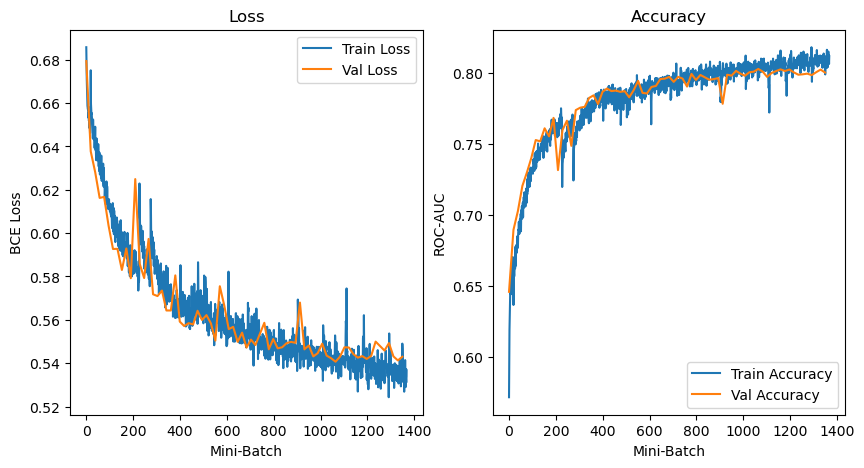

In [11]:
# Training curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
plt.plot(np.arange(0, len(train_losses), int(len(train_losses)/(len(val_losses)))), val_losses, label='Val Loss')
plt.xlabel('Mini-Batch')
plt.ylabel('BCE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(train_aucs, label='Train Accuracy')
plt.plot(np.arange(0, len(train_aucs), int(len(train_aucs)/(len(val_aucs)))), val_aucs, label='Val Accuracy')
plt.xlabel('Mini-Batch')
plt.ylabel('ROC-AUC')
plt.legend()

In [12]:
# Performance on test set
trained_model = Net().to(device)

trained_model.load_state_dict(torch.load('/kaggle/working/saved_model.pth'))
trained_model.eval()

with torch.no_grad():
    test_loss = 0.0
    test_auc = 0.0
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = trained_model(inputs)
        labels , outputs = labels.type(torch.FloatTensor),outputs.type(torch.FloatTensor)
        loss = criterion(outputs,labels)
        test_loss += loss.item()
        test_auc += roc_auc_score(labels.numpy(), outputs.numpy())

print(f"The loss on testing data is {test_loss/len(test_loader)} and the ROC-AUC is {test_auc/len(test_loader)}")

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The loss on testing data is 0.5401565978325993 and the ROC-AUC is 0.8024273118253595
